## KGB Model LN Auto V2 - Derog

In [2]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Train_Funded_Data_250324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Test_Funded_Data_250324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Oot_Funded_Data_250324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_TTD_Data_250324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 347), (62938, 347), (37121, 345), (700580, 345))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [9]:
Train.shape, Test.shape, Oot.shape

((146855, 347), (62938, 347), (37121, 345))

In [10]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(700580, 345)
(685215, 345)


In [11]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [12]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [13]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.015164618160770828, 0.015237217579204931, 0.01468171654858436)

In [14]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(200148.0, 146855, 62938)

In [15]:
all_funded= pd.concat([Train, Test]).reset_index(drop= True)
all_funded.shape

(209793, 145)

In [16]:
all_funded['client'].value_counts(dropna= False)

client
Tower       42966
Arkansas    39869
GESA        28069
Guardian    27406
Numerica    25791
SECU        18365
Bethpage    11837
CPM          9645
HFCU         2895
Hawaii       2077
NCU           873
Name: count, dtype: int64

In [17]:
all_funded['bad_flag'].mean()

0.015186398020906322

In [18]:
def get_segment(d):
    if (d['derogcount']> 0):
        return 'Derog'
    elif ((d['derogcount']== 0) and (d['assetprop']> 0)):
        return 'Property Owner'
    elif ((d['derogcount']== 0) and (d['assetprop']== 0)):
        return 'Non Property Owner'
    else:
        return 'Missing'

In [19]:
%%time
all_funded['segment']= all_funded.apply(lambda x: get_segment(x), axis= 1)
all_funded['segment'].value_counts(dropna= False)

CPU times: user 3.07 s, sys: 1.23 ms, total: 3.07 s
Wall time: 3.19 s


segment
Property Owner        117191
Non Property Owner     69928
Derog                  22674
Name: count, dtype: int64

In [20]:
all_funded.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [21]:
%%time
TTD['segment']= TTD.apply(lambda x: get_segment(x), axis= 1)
TTD['segment'].value_counts(dropna= False)

CPU times: user 9.99 s, sys: 1.55 s, total: 11.5 s
Wall time: 12.1 s


segment
Property Owner        303020
Non Property Owner    275182
Derog                 107013
Name: count, dtype: int64

In [22]:
TTD.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [23]:
%%time
Oot['segment']= Oot.apply(lambda x: get_segment(x), axis= 1)
Oot['segment'].value_counts(dropna= False)

CPU times: user 562 ms, sys: 0 ns, total: 562 ms
Wall time: 688 ms


segment
Property Owner        20750
Non Property Owner    12460
Derog                  3911
Name: count, dtype: int64

In [24]:
Oot.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  51.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [25]:
all_funded= all_funded[all_funded['segment']== 'Derog'].reset_index(drop= True)
TTD= TTD[TTD['segment']== 'Derog'].reset_index(drop= True)
Oot= Oot[Oot['segment']== 'Derog'].reset_index(drop= True)
print(all_funded.shape, all_funded['bad_flag'].mean()*100, all_funded['segment'].unique())
print(TTD.shape, TTD['segment'].unique())
print(Oot.shape, Oot['segment'].unique())
all_funded['client'].value_counts(dropna= False)

(22674, 146) 2.82261621240187 ['Derog']
(107013, 145) ['Derog']
(3911, 145) ['Derog']


client
Guardian    4269
Numerica    4252
Arkansas    3825
GESA        3511
Tower       2382
SECU        2124
CPM          933
Bethpage     789
HFCU         396
NCU          108
Hawaii        85
Name: count, dtype: int64

In [26]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(21741.0, 146855, 62938)

In [27]:
all_funded['bad_flag'].mean()

0.0282261621240187

In [28]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [29]:
### Checking for the singular value variable 
var_singular= []
for v in req_cols:
    if all_funded[v].nunique()== 1:
        print(v, all_funded[v].unique())
        var_singular.append(v)
    else:
        continue
        
var_singular, len(var_singular)

addrcurrentcorrectional [0.]
addrpreviouscorrectional [0.]
lienjudgmentforeclosurecount [0.]


(['addrcurrentcorrectional',
  'addrpreviouscorrectional',
  'lienjudgmentforeclosurecount'],
 3)

In [30]:
req_cols= [col for col in req_cols_orig if col not in var_singular]
print(req_cols)
print(len(req_cols))

['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputav

In [31]:
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/Mono_Data
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/Data

In [32]:
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/'

In [33]:
del Train, Test

In [42]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
Train, Test= train_test_split(all_funded, test_size= 0.3, random_state= 3024)
print(Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

(15871, 146) (6803, 146)
0.028101568899250206 0.02851683080993679
0.03681077928709243 0.036612804790947216


In [43]:
pref= 'Derog'
# Train.to_csv(f'{path_data}{pref}_Auto_train_raw_data_290324.csv', index= False)
# Test.to_csv(f'{path_data}{pref}_Auto_test_raw_data_290324.csv', index= False)
# Oot.to_csv(f'{path_data}{pref}_Auto_oot_raw_data_290324.csv', index= False)
# TTD.to_csv(f'{path_data}{pref}_Auto_ttd_raw_data_290324.csv', index= False)

In [44]:
all_funded['fico_pb'].isnull().sum()

22

In [45]:
all_funded.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,3825.0,26.0,0.006797
Bethpage,789.0,13.0,0.016477
CPM,933.0,22.0,0.023580
GESA,3511.0,147.0,0.041868
Guardian,4269.0,83.0,0.019442
HFCU,396.0,12.0,0.030303
Hawaii,85.0,0.0,0.000000
NCU,108.0,2.0,0.018519
Numerica,4252.0,124.0,0.029163


In [46]:
del all_funded

In [47]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.028101568899250206, 0.02851683080993679, 0.029404244438762463)

In [48]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [49]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [50]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     10969
[1]      4519
[2]       352
[-1]       31
Name: count, dtype: int64
bankruptcystatus
[0]     4684
[1]     1965
[2]      142
[-1]      12
Name: count, dtype: int64
bankruptcystatus
[0]     2693
[1]     1132
[2]       84
[-1]       2
Name: count, dtype: int64
bankruptcystatus
[0]     70207
[1]     33203
[2]      3175
[-1]      428
Name: count, dtype: int64


#### Monotonic Binning

In [51]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [52]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [53]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [54]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [55]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [56]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [57]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [58]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
0.0
assetpropevercount : [-inf, 1.0, 2.0, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 3.0, 12.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.50999999, 0.779999971, 1.0, 1.20000005, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 163000.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 1000.0, inf]
addrinputavmvalue
5159.0
addrinputavmvalue : [-inf, 101044.0, 183000.0, 295889.0, inf]
addrinputavmvalue60month
4227.0
addrinputavmvalue60month : [-inf, 55000.0, 151067.0, 304953.0, inf]
addrinputlastsaleprice
1.0
addrinputlastsaleprice : [-inf, 67000.0, 207500.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 6000.0, 138620.0, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeoldest : [-inf, 130.0, 180.0, 248.0, 313.0, 353.0, 421.0, inf]
addrinputphonecount
0.0
addrinputphonecount : [-inf, 1.0, inf]
assetpropcurrenttax

In [59]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [60]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [61]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [62]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [63]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [64]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(15871, 146) (15871, 146)
(6803, 146) (6803, 146)
(3911, 145) (3911, 145)
(107013, 145) (107013, 145)


In [65]:
binned_df.to_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_290324.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_290324.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_290324.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_290324.csv', index= False)

In [66]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [67]:
import gc
gc.collect()

0

In [68]:
pref= 'Derog'
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/'

In [69]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_290324.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_290324.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_290324.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_290324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((15871, 146), (6803, 146), (3911, 145), (107013, 145))

In [70]:
req_cols_orig= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols_orig)

130

In [71]:
# print(req_cols)

In [72]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

127

In [73]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols_orig
len(all_cols)

144

In [74]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,101937,NCU,2019-11-01,1.0,1.0,594.0,533.0,0.0,Auto,741.0,817.0,white,I,Age below 62,"[1.0, 2.0)","[2.0, inf)","[3.0, 12.0)","[-inf, 0.51)",[-1],"[1000.0, inf)",[-1],[-1],[-1],"[6000.0, 138620.0)","[353.0, 421.0)","[-inf, 1.0)","[5260.0, 326100.0)",[-1],"[67.0, 138.0)","[-inf, 8.0)","[23.0, 163.0)","[9900.0, 132700.0)","[101.0, inf)","[-inf, 0.7)","[2.0, inf)","[1.0, 2.0)","[2.0, inf)","[3.0, 4.0)","[558.0, inf)","[-inf, 1.0)","[14.0, 91.0)","[-inf, 0.1)","[17.0, 47.0)","[-inf, 1.0)","[7.0, 176.0)",[-1],"[-inf, 0.1)",[2],"[21.0, 122.0)",[-1],"[-inf, 0.1)","[-inf, 2.0)","[-inf, 0.0415)",[-1],"[-inf, 0.11)",[-1],"[351.0, 421.0)","[-inf, 4.601)",[-1],[-1],"[3731.0, inf)",[-1],"[-inf, 2.734)",[-1],"[-inf, 1.0)","[7.0, 147.0)","[24.0, 176.0)",[-1],"[-inf, 1.0)","[2.0, inf)","[-inf, 0.0507)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],0.0,[0],[0],[1],"[22.0, 122.0

In [75]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})
print(Train['segment'].unique(), Test['segment'].unique(), Oot['segment'].unique(), TTD['segment'].unique())

{'Length': 15871.0, 'Bads': 446.0, 'Bad_Rate': 2.8101568899250204}
{'Length': 6803.0, 'Bads': 194.0, 'Bad_Rate': 2.8516830809936793}
{'Length': 3911.0, 'Bads': 115.0, 'Bad_Rate': 2.940424443876246}
['Derog'] ['Derog'] ['Derog'] ['Derog']


In [76]:
Train.shape, Test.shape, Oot.shape

((15871, 146), (6803, 146), (3911, 145))

In [77]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    15871.000000
mean         2.330373
std          0.999226
min          1.174635
50%          2.047118
90%          3.469511
95%          4.206389
99%          6.195547
max         14.540287
Name: wt2, dtype: float64

In [78]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,2688,1.210890,2.011648,12.480578
Bethpage,559,1.174635,1.954800,9.766063
CPM,649,1.216081,1.990645,8.884531
GESA,2444,1.212792,2.443791,8.674707
Guardian,2991,1.219953,2.699285,14.540287
HFCU,282,1.318516,2.236557,8.384495
Hawaii,54,1.222133,2.155616,8.729644
NCU,81,1.380114,2.321961,5.058578
Numerica,2981,1.284837,2.386213,12.683987


In [79]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((15871, 145), (6803, 145), (3911, 144), (107013, 144))

In [80]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [81]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [82]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [83]:
print(Train['assetpersonal'].value_counts(dropna= False))
print(Test['assetpersonal'].value_counts(dropna= False))
print(Oot['assetpersonal'].value_counts(dropna= False))
print(TTD['assetpersonal'].value_counts(dropna= False))

assetpersonal
[0]    14417
[1]     1454
Name: count, dtype: int64
assetpersonal
[0]    6188
[1]     615
Name: count, dtype: int64
assetpersonal
[0]    3557
[1]     354
Name: count, dtype: int64
assetpersonal
[0]    99907
[1]     7106
Name: count, dtype: int64


In [84]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [85]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/'

In [86]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(15871.0, (15871, 145), 446.0, 0.028101568899250206)

In [87]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(6803.0, (6803, 145), 194.0, 0.02851683080993679)

In [88]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [89]:
df_bv= pd.DataFrame()

for col in req_cols:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                # p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                # p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
businesstitleleadership
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
proflic

In [90]:
pd.options.display.max_rows= 1000
df_bv.head(10)

,variable,Bucket,Train_BadCount,Train_BadRate,Train_Count,Test_BadCount,Test_BadRate,Test_Count,Is_Trend
0,assetpropevercount,"[-inf, 1.0)",298.0,0.047987,6210,123.0,0.047217,2605.0,Yes
1,assetpropevercount,"[1.0, 2.0)",95.0,0.017800,5337,44.0,0.018900,2328.0,Yes
2,assetpropevercount,"[2.0, inf)",53.0,0.012257,4324,27.0,0.014439,1870.0,Yes
3,sourcenonderogcount06month,"[-inf, 2.0)",356.0,0.035561,10011,156.0,0.036381,4288.0,Yes
4,sourcenonderogcount06month,"[2.0, inf)",90.0,0.015358,5860,38.0,0.015109,2515.0,Yes
5,addronfilecount,"[-inf, 3.0)",52.0,0.029034,1791,20.0,0.025031,799.0,No
6,addronfilecount,"[3.0, 12.0)",345.0,0.027629,12487,159.0,0.029904,5317.0,No
7,addronfilecount,"[12.0, inf)",49.0,0.030760,1593,15.0,0.021834,687.0,No
8,addrinputcountyratio,"[-inf, 0.51)",231.0,0.035533,6501,105.0,0.037934,2768.0,No
9,addrinputcountyratio,"[0.51, 0.78)",72.0,0.036364,1980,23.0,0.027778,828.0,No


In [91]:
var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
var_trend_break, len(var_trend_break)

(['addronfilecount',
  'addrinputcountyratio',
  'addrinputavmvalue',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'sourcecredheadertimeoldest',
  'addrinputphonecount',
  'assetpropcurrenttaxtotal',
  'addrcurrentavmvalue',
  'assetproppurchasetimeoldest',
  'addrpreviouslengthofres',
  'addrinputlengthofres',
  'addrcurrenttaxmarketvalue',
  'addrcurrenttractratio',
  'addrinputsubjectcount',
  'derogtimenewest',
  'addrinputtimelastsale',
  'educationinstitutionprivate',
  'addrinputblockratio',
  'addrcurrentlengthofres',
  'addrcurrentblockratio',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'addrcurrenttimelastsale',
  'addrinputtimeoldest',
  'addrchangecount60month',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrcurrenttimeoldest',
  'addrinputavmratio12monthprior',
  'assetpropsaletimenewest',
  'bankruptcycount24month',
  'bankruptcyti

In [93]:
var_trend_break= ['addronfilecount',
  'addrinputcountyratio',
  'addrinputavmvalue',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'sourcecredheadertimeoldest',
  'addrinputphonecount',
  'assetpropcurrenttaxtotal',
  'addrcurrentavmvalue',
  'assetproppurchasetimeoldest',
  'addrpreviouslengthofres',
  'addrinputlengthofres',
  'addrcurrenttaxmarketvalue',
  'addrcurrenttractratio',
  'addrinputsubjectcount',
  'derogtimenewest',
  'addrinputtimelastsale',
  'educationinstitutionprivate',
  'addrinputblockratio',
  'addrcurrentlengthofres',
  'addrcurrentblockratio',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'addrcurrenttimelastsale',
  'addrinputtimeoldest',
  'addrchangecount60month',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrcurrenttimeoldest',
  'addrinputavmratio12monthprior',
  'assetpropsaletimenewest',
  'bankruptcycount24month',
  'bankruptcytimenewest',
  'criminalfelonytimenewest',
  'lienjudgmentcount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest',
  'subjectrecordtimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(41, 41)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [94]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [95]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [96]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxgj0pb5y
  JVM stdout: /tmp/tmpxgj0pb5y/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxgj0pb5y/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_unknownUser_7ejg5s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [97]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [98]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(15871, 145) (15871, 145) (6803, 145) (6803, 145) (3911, 144) (107013, 144)


(0.028101568899250206, 0.02851683080993679)

In [99]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [100]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (10969, 145)
[2] (1187, 145)
[1] (3713, 145)
[-1] (2, 145)


In [101]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[2.0, inf)","[3.0, 12.0)","[-inf, 0.51)",[-1],"[1000.0, inf)",[-1],[-1],[-1],"[6000.0, 138620.0)","[353.0, 421.0)","[-inf, 1.0)","[5260.0, 326100.0)",[-1],"[67.0, 138.0)","[-inf, 8.0)","[23.0, 163.0)","[9900.0, 132700.0)","[101.0, inf)","[-inf, 0.7)","[2.0, inf)","[1.0, 2.0)","[2.0, inf)","[3.0, 4.0)","[558.0, inf)","[-inf, 1.0)","[14.0, 91.0)","[-inf, 0.1)","[17.0, 47.0)","[-inf, 1.0)","[7.0, 176.0)",[-1],"[-inf, 0.1)",[2],"[21.0, 122.0)",[-1],"[-inf, 0.1)","[-inf, 2.0)","[-inf, 0.0415)",[-1],"[-inf, 0.11)",[-1],"[351.0, 421.0)","[-inf, 4.601)",[-1],[-1],"[3731.0, inf)",[-1],"[-inf, 2.734)",[-1],"[-inf, 1.0)","[7.0, 147.0)","[24.0, 176.0)",[-1],"[-inf, 1.0)","[2.0, inf)","[-inf, 0.0507)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],[0],[0],[1],"[22.0, 122.0)",[-1],[-1],[0],[0],[0],[1],[1],[0],[0],[0],[-1],"[124.0, 191.0)",[1],[1],[0],"[-inf, 0.217)",[1],[0],"[-inf, 0.0776)","[31.0, inf)","[-inf, 0.135)",[-1],"[-inf, 0.0232)",[0],"[-inf, 0.0449)","[-inf, 0.00221)",[0],[-1],[1],"[-inf, 0.0321)","[-inf, 0.00183)",[-1],"[-inf, 0.00807)","[-inf, 1.0)",[0],

In [102]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [103]:
# req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 127)

In [104]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [105]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

72

In [106]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [107]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_auto_wt_segment_with_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [108]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 1.46 s, sys: 90 ms, total: 1.55 s
Wall time: 5min 39s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_Derog


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.031963390059514395
RMSE: 0.17878308102142773
LogLoss: 0.131139253099666
Mean Per-Class Error: 0.3693962849199034
AUC: 0.8080346639584731
AUCPR: 0.24343433147804497
Gini: 0.6160693279169462

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11700638162501832
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      34394  1229  0.0345   (1229.0/35623.0)
1      958    402   0.7044   (958.0/1360.0)
Total  35352  1631  0.0591   (2187.0/36983.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.117006     0.268981  114
max f2                       0.0629082    0.34165   202
max f0point5                 0.213316     0.350124  45
max accuracy                 0.268126     0.965348  29
max precision                0.655228     1         0
max recall                   0.00310403   1         395
max specificity              0.655228     1         0
max absolute_mcc             0.224604     0.268215  41
max min_per_class_accuracy   0.0413144    0.726264  254
max mean_per_class_accuracy  0.0436318    0.732749  248
max tns                      0.655228     35623.9   0
max fns                      0.655228     1349.1    0
max fps                      0.0013342    35623.9   399
max tps                      0.00310403   1361.46   395
max tnr                      0.655228     1         0
max fnr                      0.655228     0.990922  0
max fpr                      0.0013342    1         399
max tpr                      0.00310403   1         395

Gains/Lift Table: Avg response rate:  3.96 %, avg score:  4.77 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00694031                  0.257349           16.9588    16.9588            0.671717         0.403694    0.671717                    0.403694            0.117699        0.117699                   1595.88   1595.88            0.115327
2        0.0191384                   0.176456           5.36859    9.57163            0.212644         0.237322    0.379121                    0.297655            0.0654867       0.183186                   436.859   857.163            0.170813
3        0.0310912                   0.144539           4.59035    7.65661            0.181818         0.180749    0.303269                    0.252711            0.0548673       0.238053                   359.035   665.661            0.215498
4        0.0429388                   0.124097           3.73475    6.5745             0.147929         0.151893    0.260408                    0.224893            0.0442478       0.282301                   273.475   557.45             0.249234
5        0.0543657                   0.113254           3.40756    5.90885            0.134969         0.13593     0.234043                    0.206194            0.0389381       0.321239                   240.756   490.885            0.27788
6        0.110554                    0.0806235          2.48847    4.17046            0.0985652        0.110405    0.165187                    0.15751             0.139823        0.461062                   148.847   317.046            0.364964
7        0.166252                    0.0649918          1.9384

##### Train Predictions

In [109]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [110]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [111]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
36985.34969646054 1361.4595445323403 14.540287309327484


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.053781,0.655228,0.093532,7402.515147,6564.759165,837.755982,11.32,20.01,18.43,61.53,43.10
1,0.029926,0.053776,0.039937,7394.250003,7099.831690,294.418313,3.98,40.01,38.36,83.16,44.80
2,0.017728,0.029920,0.023166,7395.510078,7259.781729,135.728348,1.84,60.00,58.74,93.13,34.39
3,0.009929,0.017725,0.013372,7397.774230,7326.271281,71.502949,0.97,80.00,79.30,98.38,19.08
4,0.000728,0.009927,0.006380,7395.300239,7373.246287,22.053953,0.30,100.00,100.00,100.00,0.00


{'Gini': 56.54, 'KS': 44.8}


In [112]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
15799.018119535182 578.4463662991794 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.052213,0.444854,0.091877,3160.911411,2903.111376,257.800034,8.16,20.01,19.07,44.57,25.50
1,0.028911,0.052149,0.038798,3161.485798,3019.882698,141.603101,4.48,40.02,38.91,69.05,30.14
2,0.017498,0.028903,0.022746,3157.307641,3062.940467,94.367175,2.99,60.00,59.04,85.36,26.32
3,0.009848,0.017494,0.013256,3159.774472,3102.311146,57.463326,1.82,80.00,79.42,95.30,15.88
4,0.000413,0.009848,0.006332,3159.538797,3132.326067,27.212730,0.86,100.00,100.00,100.00,0.00


{'Gini': 39.14, 'KS': 30.14}


#### Non-weighted

In [113]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
15871 446.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.041489,0.655228,0.077999,3175,2896.0,279.0,8.79,20.01,18.77,62.56,43.79
1,0.023082,0.041477,0.031013,3174,3089.0,85.0,2.68,40.00,38.80,81.61,42.81
2,0.013831,0.023080,0.018010,3174,3120.0,54.0,1.70,60.00,59.03,93.72,34.69
3,0.008316,0.013829,0.010969,3174,3156.0,18.0,0.57,80.00,79.49,97.76,18.27
4,0.000728,0.008316,0.005538,3174,3164.0,10.0,0.32,100.00,100.00,100.00,0.00


{'Gini': 55.83, 'KS': 43.79}


In [114]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6803 194.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.040999,0.444854,0.076899,1361,1274.0,87.0,6.39,20.01,19.28,44.85,25.57
1,0.022992,0.040929,0.030476,1361,1313.0,48.0,3.53,40.01,39.14,69.59,30.45
2,0.013699,0.022988,0.017895,1360,1325.0,35.0,2.57,60.00,59.19,87.63,28.44
3,0.008278,0.013699,0.010938,1361,1345.0,16.0,1.18,80.01,79.54,95.88,16.34
4,0.000413,0.008267,0.005521,1360,1352.0,8.0,0.59,100.00,100.00,100.00,0.00


{'Gini': 40.32, 'KS': 30.45}


In [115]:
Oot['wt2']= 1
TTD['wt2']= 1

In [116]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3911 115.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.040426,0.617513,0.078084,783,726.0,57.0,7.28,20.02,19.13,49.57,30.44
1,0.022429,0.040372,0.030055,782,758.0,24.0,3.07,40.02,39.09,70.43,31.34
2,0.013731,0.022387,0.017718,782,761.0,21.0,2.69,60.01,59.14,88.70,29.56
3,0.008316,0.013731,0.010903,782,775.0,7.0,0.90,80.01,79.56,94.78,15.22
4,0.000728,0.008316,0.005492,782,776.0,6.0,0.77,100.00,100.00,100.00,0.00


{'Gini': 42.620000000000005, 'KS': 31.34}


In [117]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'sourcenonderogcount', 'inquiryshortterm12month', 'assetpropevercount', 'bankruptcystatus', 'criminalfelonycount', 'derogcount12month', 'evictioncount12month', 'criminalnonfelonycount', 'addrprevioustimeoldest', 'addrchangecount06month', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'derogcount', 'bankruptcydismissed24month', 'inquirytelcom12month', 'lienjudgmenttaxcount', 'assetpropnewestmortgagetype', 'shorttermloanrequest', 'evictioncount', 'assetpersonalcount', 'bankruptcychapter', 'addrcurrentsubjectowned', 'businessassociationtimeoldest', 'addrinputdeedmailing', 'addrcurrentdeedmailing', 'sourcenonderogcount12month', 'inquirybanking12month', 'businessassociation', 'addrinputproblems', 'addrchangecount12month', 'assetpropnewestsaleprice', 'inquirycollections12month', 'educationprogramattended', 'assetpropsalepurchaseratio', 'criminalnonfelonycount12month', 'profliccount', 'lienjudgmentcount12month', 'addrinputtaxmarketvalue', 'addrinp

In [118]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],12219.111328,1.000000,0.127800,assetownership
1,inquiryauto12month.[0],9555.112305,0.781981,0.099937,inquiryauto12month
2,"sourcenonderogcount.[4.0, inf)",5843.646484,0.478238,0.061119,sourcenonderogcount
3,inquiryshortterm12month.[0],4601.744141,0.376602,0.048130,inquiryshortterm12month
4,"assetpropevercount.[-inf, 1.0)",3551.657227,0.290664,0.037147,assetpropevercount
5,bankruptcystatus.[1],3026.739258,0.247705,0.031657,bankruptcystatus
6,"criminalfelonycount.[-inf, 0.0321)",2861.029297,0.234144,0.029924,criminalfelonycount
7,"derogcount12month.[-inf, 1.0)",2676.735107,0.219061,0.027996,derogcount12month
8,"evictioncount12month.[-inf, 0.00491)",2634.406738,0.215597,0.027553,evictioncount12month
9,"sourcenonderogcount.[-inf, 2.0)",2492.913574,0.204018,0.026073,sourcenonderogcount


## HyperOpt

In [119]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
# len(col_list)
# 41
# col_list = ['inquiryauto12month', 'inquiryshortterm12month', 'addrlastmovetaxratiodiff', 'sourcenonderogcount', 'addrcurrenttractratio', 'sourcenonderogcount03month', 'addrchangecount03month', 'inquirycollections12month', 'inquirynonshortterm12month', 'sourcenonderogcount12month', 'educationprogramattended', 'addrinputsubjectcount', 'assetpropevercount', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrentavmratio12monthprior', 'addrchangecount24month', 'addrinputdeedmailing', 'addrchangecount06month', 'assetpropnewestsaleprice', 'businessassociation', 'assetpropcurrentcount', 'addrchangecount12month', 'addrinputphoneservice', 'assetpropnewestmortgagetype', 'addrcurrentsubjectowned', 'addrcurrentdeedmailing', 'profliccount', 'addrcurrenttimenewest', 'assetpropsoldcount12month', 'addrcurrenttimelastsale', 'assetpropsalepurchaseratio', 'addrinputavmratio12monthprior', 'addrinputsubjectowned', 'educationattendance', 'subjectnewestrecord12month', 'addrinputproblems', 'assetpersonalcount', 'assetproppurchasecount12month', 'sourcenonderogcount06month', 'inquirytelcom12month']
len(col_list)

53

In [120]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [121]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [122]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [123]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputtaxmarketvalue,sourcenonderogcount12month,assetpropcurrentcount,sourcenonderogcount,addrinputtaxvalue,businessassociationtimeoldest,addrchangecount24month,addrcurrentavmratio12monthprior,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrenttimenewest,lienjudgmentdollartotal,addrinputtimenewest,bankruptcycount,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalnonfelonycount12month,derogcount12month,educationattendance,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month
"[2.0, inf)","[2.0, inf)",[-1],"[-inf, 1000.0)","[-inf, 6000.0)","[2.0, inf)","[2.0, inf)","[4.0, inf)","[-inf, 558.0)",[-1],"[-inf, 1.0)",[-1],"[-inf, 2.0)","[-inf, 0.0415)",[-1],"[-inf, 4.601)","[3731.0, inf)","[-inf, 2.734)","[-inf, 1.0)",[-1],"[-inf, 1.0)","[2.0, inf)","[-inf, 0.0507)","[-inf, 1.0)","[-inf, 1.0)",[1],[0],[0],[1],[0],[0],[0],[0],[0],[0],"[48.0, 124.0)",[1],[1],"[0.217, inf)",[1],[-1],"[-inf, 0.0776)","[31.0, inf)","[-inf, 0.135)","[-inf, 0.0232)",[0],"[-inf, 0.00221)",[0],[0],"[-inf, 0.0321)","[-inf, 0.00183)","[-inf, 0.00807)","[-inf, 1.0)",[0],[0],"[-inf, 0.0457)","[-inf, 0.00491)",[0],[1],[0],[1],[0],[0],"[-inf, 1.0)","[-inf, 1.0)","[-inf, 0.0135)","[-inf, 1.0)","[1.0, 2.0)",[0],[0],[0],[1]
"[1.0, 2.0)","[-inf, 2.0)",[-1],"[1000.0, inf)","[138620.0, inf)","[-inf, 2.0)","[1.0, 2.0)","[3.0, 4.0)","[558.0, inf)",[-1],"[-inf, 1.0)","[1.41, inf)","[2.0, inf)","[-inf, 0.0415)","[-inf, 1.58)","[-inf, 4.601)","[3731.0, inf)","[-inf, 2.734)","[-inf, 1.0)",[-1],"[-inf, 1.0)","[-inf, 2.0)","[-inf, 0.0507)","[-inf, 1.0)","[-inf, 1.0)",[0],[0],[1],[0],[0],[0],[1],[0],[0],[0],"[48.0, 124.0)",[1],[1],"[-inf, 0.217)",[1],[0],"[-inf, 0.0776)","[31.0, inf)","[-inf, 0.135)","[-inf, 0.0232)",[0],"[-inf, 0.00221)",[0],[0],"[-inf, 0.0321)","[-inf, 0.00183)","[-inf, 0.00807)","[-inf, 1.0)",[0],[0],"[-inf, 0.0457)","[-inf, 0.00491)",[0],[1],[0],[1],[0],[0],"[-inf, 1.0)","[-inf, 1.0)","[-inf, 0.0135)","[1.0, inf)","[-inf, 1.0)",[0],[0],[0],[1]
"[-inf, 1.0)","[-inf, 2.0)",[-1],"[-inf, 1000.0)","[-inf, 6000.0)","[-inf, 2.0)","[-inf, 1.0)","[-inf, 2.0)","[-inf, 558.0)",[-1],"[-inf, 1.0)",[-1],"[2.0, inf)","[-inf, 0.0415)",[-1],"[-inf, 4.601)","[-inf, 424.0)","[-inf, 2.734)","[-inf, 1.0)",[-1],"[-inf, 1.0)","[-inf, 2.0)","[-inf, 0.0507)","[-inf, 1.0)","[-inf, 1.0)",[-1],[0],[-1],[-1],[0],[0],[-1],[0],[0],[0],"[191.0, inf)",[1],[0],"[-inf, 0.217)",[0],[-1],"[-inf, 0.0776)",[-1],"[-inf, 0.135)","[-inf, 0.0232)",[0],"[-inf, 0.00221)",[0],[0],"[-inf, 0.0321)","[-inf, 0.00183)","[-inf, 0.00807)","[1.0, inf)",[0],[0],"[0.0457, inf)","[0.00491, inf)",[0],[0],[0],[0],[0],[0],"[-inf, 1.0)","[-inf, 1.0)","[-inf, 0.0135)","[-inf, 1.0)","[-inf, 1.0)",[0],[0],[0],[1]
"[-inf, 1.0)","[-inf, 2.0)",[-1],"[-inf, 1000.0)","[-inf, 6000.0)","[-inf, 2.0)","[-inf, 1.0)","[3.0, 4.0)","[-inf, 558.0)",[-1],"[-inf, 1.0)","[-inf, 1.41)","[-inf, 2.0)","[-inf, 

In [124]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [125]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [126]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [127]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=120,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/120 [00:21<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036674,0.026937,0.008235,0.016358,0.02924,0.046016,0.190087


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5510, 'approved_control': 39772}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7584, 'approved_control': 26945}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4556, 'approved_control': 26945}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3028, 'approved_control': 26945}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16460, 'approved_control': 26280}
{'AIR ttd age_cuts': [1.4797], 'AIR ttd Race': [0.7864], 'AIR ttd Raceblack': [0.766], 'AIR ttd Racehispanic': [0.8194], 'AIR ttd Gender': [0.9016]}
{'loss': 0.17815713788588677, 'status': 'ok', 'KS_diff': 6.460000000000001, 'train_ks': 31.95, 'test_ks': 25.49, 'gini_diff': 5.060000000000002, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03633,0.02826,0.009138,0.016511,0.026667,0.04636,0.293306


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5667, 'approved_control': 39633}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6910, 'approved_control': 27814}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4190, 'approved_control': 27814}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2720, 'approved_control': 27814}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17062, 'approved_control': 25736}
{'AIR ttd age_cuts': [1.527], 'AIR ttd Race': [0.6943], 'AIR ttd Raceblack': [0.6825], 'AIR ttd Racehispanic': [0.7133], 'AIR ttd Gender': [0.9544]}
{'loss': 0.22173117750301705, 'status': 'ok', 'KS_diff': 8.230000000000004, 'train_ks': 38.38, 'test_ks': 30.15, 'gini_diff': 9.240000000000002, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.049274,0.0,0.049274,0.049274,0.049274,0.049274,0.049274


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03631,0.023802,0.011731,0.017347,0.029007,0.047827,0.164983


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5713, 'approved_control': 39579}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7187, 'approved_control': 27555}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4206, 'approved_control': 27555}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2981, 'approved_control': 27555}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16542, 'approved_control': 26248}
{'AIR ttd age_cuts': [1.5416], 'AIR ttd Race': [0.7289], 'AIR ttd Raceblack': [0.6915], 'AIR ttd Racehispanic': [0.789], 'AIR ttd Gender': [0.9073]}
{'loss': 0.20261855279644736, 'status': 'ok', 'KS_diff': 4.599999999999998, 'train_ks': 35.48, 'test_ks': 30.88, 'gini_diff': 5.700000000000003, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036831,0.040773,0.00172,0.012214,0.022699,0.045129,0.556693


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5324, 'approved_control': 39969}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6667, 'approved_control': 27736}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4238, 'approved_control': 27736}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2429, 'approved_control': 27736}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17416, 'approved_control': 25274}
{'AIR ttd age_cuts': [1.4227], 'AIR ttd Race': [0.6717], 'AIR ttd Raceblack': [0.6922], 'AIR ttd Racehispanic': [0.6386], 'AIR ttd Gender': [0.9919]}
{'loss': 0.2432652227813391, 'status': 'ok', 'KS_diff': 12.939999999999998, 'train_ks': 42.48, 'test_ks': 29.54, 'gini_diff': 14.019999999999996, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.034852,0.031993,0.004867,0.013793,0.02357,0.04407,0.333483


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5247, 'approved_control': 40027}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6783, 'approved_control': 27784}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4248, 'approved_control': 27784}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2535, 'approved_control': 27784}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16934, 'approved_control': 25837}
{'AIR ttd age_cuts': [1.4], 'AIR ttd Race': [0.6822], 'AIR ttd Raceblack': [0.6927], 'AIR ttd Racehispanic': [0.6653], 'AIR ttd Gender': [0.9435]}
{'loss': 0.2298639133602935, 'status': 'ok', 'KS_diff': 8.950000000000003, 'train_ks': 38.24, 'test_ks': 29.29, 'gini_diff': 7.990000000000002, 'train_gini': 45

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036639,0.002147,0.034412,0.034412,0.036881,0.038887,0.038887


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5414, 'approved_control': 39856}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7514, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4482, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3032, 'approved_control': 27013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16045, 'approved_control': 26689}
{'AIR ttd age_cuts': [1.4505], 'AIR ttd Race': [0.7774], 'AIR ttd Raceblack': [0.7518], 'AIR ttd Racehispanic': [0.8186], 'AIR ttd Gender': [0.8656]}
{'loss': 0.18477531493350985, 'status': 'ok', 'KS_diff': 1.2800000000000011, 'train_ks': 27.84, 'test_ks': 26.56, 'gini_diff': 0.5300000000000011, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037387,0.003837,0.03346,0.03346,0.036882,0.041458,0.041458


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.033468,0.034543,0.003478,0.011842,0.020733,0.04154,0.365141


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5144, 'approved_control': 40161}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6877, 'approved_control': 27739}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4265, 'approved_control': 27739}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2612, 'approved_control': 27739}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17389, 'approved_control': 25339}
{'AIR ttd age_cuts': [1.3678], 'AIR ttd Race': [0.6928], 'AIR ttd Raceblack': [0.6966], 'AIR ttd Racehispanic': [0.6867], 'AIR ttd Gender': [0.988]}
{'loss': 0.2255261150985931, 'status': 'ok', 'KS_diff': 7.869999999999997, 'train_ks': 37.8, 'test_ks': 29.93, 'gini_diff': 8.399999999999999, 'train_gini': 4

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036756,0.010688,0.022784,0.026306,0.036997,0.046455,0.059644


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5402, 'approved_control': 39881}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7534, 'approved_control': 27139}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4520, 'approved_control': 27139}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3014, 'approved_control': 27139}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15932, 'approved_control': 26826}
{'AIR ttd age_cuts': [1.4466], 'AIR ttd Race': [0.7756], 'AIR ttd Raceblack': [0.7545], 'AIR ttd Racehispanic': [0.8099], 'AIR ttd Gender': [0.8551]}
{'loss': 0.18463101546007268, 'status': 'ok', 'KS_diff': 5.560000000000002, 'train_ks': 30.89, 'test_ks': 25.33, 'gini_diff': 5.450000000000003, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035874,0.031649,0.007971,0.014866,0.024736,0.045692,0.362849


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5667, 'approved_control': 39636}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7100, 'approved_control': 27557}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4303, 'approved_control': 27557}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2797, 'approved_control': 27557}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17276, 'approved_control': 25488}
{'AIR ttd age_cuts': [1.527], 'AIR ttd Race': [0.7199], 'AIR ttd Raceblack': [0.7074], 'AIR ttd Racehispanic': [0.7403], 'AIR ttd Gender': [0.9759]}
{'loss': 0.2098437574729471, 'status': 'ok', 'KS_diff': 7.029999999999998, 'train_ks': 37.3, 'test_ks': 30.27, 'gini_diff': 8.75, 'train_gini': 46.92, 'test_g

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035847,0.036545,0.005136,0.012744,0.022661,0.045337,0.450664


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5573, 'approved_control': 39724}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6883, 'approved_control': 27741}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4257, 'approved_control': 27741}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2626, 'approved_control': 27741}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17210, 'approved_control': 25543}
{'AIR ttd age_cuts': [1.4984], 'AIR ttd Race': [0.6933], 'AIR ttd Raceblack': [0.6952], 'AIR ttd Racehispanic': [0.6904], 'AIR ttd Gender': [0.9702]}
{'loss': 0.22672907450116997, 'status': 'ok', 'KS_diff': 8.79, 'train_ks': 39.9, 'test_ks': 31.11, 'gini_diff': 10.479999999999997, 'train_gini': 49.47, 'tes

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03592,0.034925,0.005776,0.013191,0.023576,0.045639,0.454085


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5645, 'approved_control': 39656}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6976, 'approved_control': 27675}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4264, 'approved_control': 27675}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2712, 'approved_control': 27675}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17122, 'approved_control': 25658}
{'AIR ttd age_cuts': [1.5204], 'AIR ttd Race': [0.7044], 'AIR ttd Raceblack': [0.6981], 'AIR ttd Racehispanic': [0.7148], 'AIR ttd Gender': [0.9607]}
{'loss': 0.22083082060094522, 'status': 'ok', 'KS_diff': 10.560000000000002, 'train_ks': 39.89, 'test_ks': 29.33, 'gini_diff': 11.160000000000004, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03608,0.033776,0.005527,0.013568,0.024059,0.046103,0.324332


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5633, 'approved_control': 39674}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7017, 'approved_control': 27694}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4280, 'approved_control': 27694}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2737, 'approved_control': 27694}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17361, 'approved_control': 25423}
{'AIR ttd age_cuts': [1.5165], 'AIR ttd Race': [0.708], 'AIR ttd Raceblack': [0.7], 'AIR ttd Racehispanic': [0.7207], 'AIR ttd Gender': [0.9832]}
{'loss': 0.2126209691939377, 'status': 'ok', 'KS_diff': 5.840000000000003, 'train_ks': 38.1, 'test_ks': 32.26, 'gini_diff': 5.719999999999999, 'train_gini': 46.3

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036191,0.038277,0.003737,0.012024,0.022135,0.045677,0.482996


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5729, 'approved_control': 39584}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7040, 'approved_control': 27527}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4360, 'approved_control': 27527}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2680, 'approved_control': 27527}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17473, 'approved_control': 25278}
{'AIR ttd age_cuts': [1.5457], 'AIR ttd Race': [0.7147], 'AIR ttd Raceblack': [0.7175], 'AIR ttd Racehispanic': [0.7101], 'AIR ttd Gender': [0.9951]}
{'loss': 0.21425810525047934, 'status': 'ok', 'KS_diff': 8.190000000000001, 'train_ks': 39.74, 'test_ks': 31.55, 'gini_diff': 9.549999999999997, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.051579,0.0,0.051579,0.051579,0.051579,0.051579,0.051579


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036828,0.024578,0.011575,0.017832,0.030289,0.046463,0.151394


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5770, 'approved_control': 39526}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7338, 'approved_control': 27389}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4279, 'approved_control': 27389}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3059, 'approved_control': 27389}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16562, 'approved_control': 26206}
{'AIR ttd age_cuts': [1.559], 'AIR ttd Race': [0.7488], 'AIR ttd Raceblack': [0.7079], 'AIR ttd Racehispanic': [0.8146], 'AIR ttd Gender': [0.9096]}
{'loss': 0.19204901361532806, 'status': 'ok', 'KS_diff': 4.380000000000003, 'train_ks': 33.96, 'test_ks': 29.58, 'gini_diff': 4.759999999999991, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03619,0.02678,0.01006,0.016993,0.027314,0.047299,0.261019


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5714, 'approved_control': 39576}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7129, 'approved_control': 27625}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4228, 'approved_control': 27625}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2901, 'approved_control': 27625}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16980, 'approved_control': 25797}
{'AIR ttd age_cuts': [1.5419], 'AIR ttd Race': [0.7211], 'AIR ttd Raceblack': [0.6933], 'AIR ttd Racehispanic': [0.7658], 'AIR ttd Gender': [0.9475]}
{'loss': 0.20735478077140923, 'status': 'ok', 'KS_diff': 7.869999999999997, 'train_ks': 38.05, 'test_ks': 30.18, 'gini_diff': 10.010000000000005, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035512,0.036084,0.004974,0.012827,0.023059,0.044353,0.485723


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5588, 'approved_control': 39710}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6966, 'approved_control': 27673}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4268, 'approved_control': 27673}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2698, 'approved_control': 27673}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17265, 'approved_control': 25498}
{'AIR ttd age_cuts': [1.5027], 'AIR ttd Race': [0.7033], 'AIR ttd Raceblack': [0.6987], 'AIR ttd Racehispanic': [0.711], 'AIR ttd Gender': [0.9747]}
{'loss': 0.22084531193561285, 'status': 'ok', 'KS_diff': 8.93, 'train_ks': 40.57, 'test_ks': 31.64, 'gini_diff': 10.830000000000005, 'train_gini': 50.77, 'tes

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035776,0.030287,0.007844,0.015344,0.025392,0.045782,0.38265


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5685, 'approved_control': 39614}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6933, 'approved_control': 27726}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4193, 'approved_control': 27726}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2740, 'approved_control': 27726}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17198, 'approved_control': 25599}
{'AIR ttd age_cuts': [1.5327], 'AIR ttd Race': [0.6988], 'AIR ttd Raceblack': [0.6851], 'AIR ttd Racehispanic': [0.7208], 'AIR ttd Gender': [0.9673]}
{'loss': 0.22018142672226654, 'status': 'ok', 'KS_diff': 6.090000000000003, 'train_ks': 38.85, 'test_ks': 32.76, 'gini_diff': 8.730000000000004, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.07278,0.0,0.07278,0.07278,0.07278,0.07278,0.07278


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.051735,0.0,0.051735,0.051735,0.051735,0.051735,0.051735


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.043827,3.469463e-17,0.043827,0.043827,0.043827,0.043827,0.043827


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03603,0.007536,0.027317,0.02823,0.035092,0.041233,0.050869


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5569, 'approved_control': 39710}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7582, 'approved_control': 27117}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4509, 'approved_control': 27117}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3073, 'approved_control': 27117}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16094, 'approved_control': 26678}
{'AIR ttd age_cuts': [1.4975], 'AIR ttd Race': [0.7813], 'AIR ttd Raceblack': [0.7534], 'AIR ttd Racehispanic': [0.8264], 'AIR ttd Gender': [0.8686]}
{'loss': 0.1780424630705974, 'status': 'ok', 'KS_diff': 4.059999999999999, 'train_ks': 30.02, 'test_ks': 25.96, 'gini_diff': 4.3700000000000045, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037667,0.002286,0.035305,0.035305,0.037734,0.040072,0.040072


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5414, 'approved_control': 39856}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7514, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4482, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3032, 'approved_control': 27013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16045, 'approved_control': 26689}
{'AIR ttd age_cuts': [1.4505], 'AIR ttd Race': [0.7774], 'AIR ttd Raceblack': [0.7518], 'AIR ttd Racehispanic': [0.8186], 'AIR ttd Gender': [0.8656]}
{'loss': 0.18477531493350985, 'status': 'ok', 'KS_diff': 1.2800000000000011, 'train_ks': 27.84, 'test_ks': 26.56, 'gini_diff': 0.5300000000000011, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.034588,0.010947,0.020838,0.023931,0.033551,0.043523,0.056042


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5337, 'approved_control': 39947}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7560, 'approved_control': 27068}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4566, 'approved_control': 27068}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2994, 'approved_control': 27068}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15918, 'approved_control': 26851}
{'AIR ttd age_cuts': [1.4268], 'AIR ttd Race': [0.7804], 'AIR ttd Raceblack': [0.7642], 'AIR ttd Racehispanic': [0.8066], 'AIR ttd Gender': [0.8533]}
{'loss': 0.18383893782956645, 'status': 'ok', 'KS_diff': 5.149999999999999, 'train_ks': 31.65, 'test_ks': 26.5, 'gini_diff': 6.0, 'train_gini': 37.26, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.068995,0.0,0.068995,0.068995,0.068995,0.068995,0.068995


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.040341,0.001106,0.039301,0.039301,0.039301,0.041517,0.041517


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5412, 'approved_control': 39866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7359, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 27251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16517, 'approved_control': 26223}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.8144], 'AIR ttd Gender': [0.9068]}
{'loss': 0.19690263684834347, 'status': 'ok', 'KS_diff': 2.129999999999999, 'train_ks': 23.52, 'test_ks': 25.65, 'gini_diff': 0.23000000000000043, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037968,0.018091,0.015913,0.022321,0.033952,0.048741,0.093592


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5399, 'approved_control': 39888}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7492, 'approved_control': 27123}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4523, 'approved_control': 27123}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2969, 'approved_control': 27123}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15925, 'approved_control': 26852}
{'AIR ttd age_cuts': [1.4455], 'AIR ttd Race': [0.7718], 'AIR ttd Raceblack': [0.7554], 'AIR ttd Racehispanic': [0.7984], 'AIR ttd Gender': [0.8537]}
{'loss': 0.18424233478699498, 'status': 'ok', 'KS_diff': 2.91, 'train_ks': 28.66, 'test_ks': 25.75, 'gini_diff': 4.609999999999999, 'train_gini': 38.82, 'tes

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.053404,2.775571e-17,0.053404,0.053404,0.053404,0.053404,0.053404


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.0365,0.018165,0.013977,0.021151,0.033281,0.046827,0.10408


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5374, 'approved_control': 39905}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7649, 'approved_control': 26831}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4606, 'approved_control': 26831}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 26831}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16081, 'approved_control': 26666}
{'AIR ttd age_cuts': [1.4382], 'AIR ttd Race': [0.7966], 'AIR ttd Raceblack': [0.7778], 'AIR ttd Racehispanic': [0.8271], 'AIR ttd Gender': [0.8681]}
{'loss': 0.17360681101740524, 'status': 'ok', 'KS_diff': 5.440000000000001, 'train_ks': 30.44, 'test_ks': 25.0, 'gini_diff': 5.0, 'train_gini': 39.23, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036741,0.008435,0.026656,0.028018,0.039326,0.043785,0.050929


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5530, 'approved_control': 39741}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7496, 'approved_control': 27106}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4437, 'approved_control': 27106}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3059, 'approved_control': 27106}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15963, 'approved_control': 26797}
{'AIR ttd age_cuts': [1.4861], 'AIR ttd Race': [0.7727], 'AIR ttd Raceblack': [0.7416], 'AIR ttd Racehispanic': [0.8231], 'AIR ttd Gender': [0.8576]}
{'loss': 0.18281118693435397, 'status': 'ok', 'KS_diff': 3.280000000000001, 'train_ks': 29.12, 'test_ks': 25.84, 'gini_diff': 3.1599999999999966, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.049596,6.938926e-17,0.049596,0.049596,0.049596,0.049596,0.049596


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037333,0.010368,0.026169,0.026169,0.039301,0.046834,0.050163


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5486, 'approved_control': 39794}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7441, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4363, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3078, 'approved_control': 27192}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16130, 'approved_control': 26611}
{'AIR ttd age_cuts': [1.4723], 'AIR ttd Race': [0.7646], 'AIR ttd Raceblack': [0.727], 'AIR ttd Racehispanic': [0.8256], 'AIR ttd Gender': [0.8725]}
{'loss': 0.18324196585459884, 'status': 'ok', 'KS_diff': 3.0, 'train_ks': 29.75, 'test_ks': 26.75, 'gini_diff': 2.950000000000003, 'train_gini': 38.2, 'test_g

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036859,0.029838,0.007101,0.015381,0.027545,0.047919,0.232421


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5495, 'approved_control': 39792}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7509, 'approved_control': 27062}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4543, 'approved_control': 27062}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2966, 'approved_control': 27062}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16725, 'approved_control': 25997}
{'AIR ttd age_cuts': [1.4748], 'AIR ttd Race': [0.7754], 'AIR ttd Raceblack': [0.7605], 'AIR ttd Racehispanic': [0.7992], 'AIR ttd Gender': [0.9263]}
{'loss': 0.18223295020881486, 'status': 'ok', 'KS_diff': 5.48, 'train_ks': 35.21, 'test_ks': 29.73, 'gini_diff': 7.109999999999999, 'train_gini': 44.52999999

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.052889,6.245034e-17,0.052889,0.052889,0.052889,0.052889,0.052889


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035742,0.006775,0.02793,0.028454,0.036588,0.042187,0.04574


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5451, 'approved_control': 39829}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7559, 'approved_control': 27130}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4456, 'approved_control': 27130}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3103, 'approved_control': 27130}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16040, 'approved_control': 26699}
{'AIR ttd age_cuts': [1.4616], 'AIR ttd Race': [0.7785], 'AIR ttd Raceblack': [0.7442], 'AIR ttd Racehispanic': [0.8342], 'AIR ttd Gender': [0.8648]}
{'loss': 0.178474975870779, 'status': 'ok', 'KS_diff': 1.5300000000000011, 'train_ks': 30.11, 'test_ks': 28.58, 'gini_diff': 2.4200000000000017, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036314,0.00696,0.029246,0.029246,0.034729,0.043736,0.043736


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037079,0.003118,0.033874,0.033874,0.036881,0.040377,0.040377


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036383,0.003917,0.032052,0.032052,0.038363,0.0398,0.041141


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5486, 'approved_control': 39794}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7441, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4363, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3078, 'approved_control': 27192}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16130, 'approved_control': 26611}
{'AIR ttd age_cuts': [1.4723], 'AIR ttd Race': [0.7646], 'AIR ttd Raceblack': [0.727], 'AIR ttd Racehispanic': [0.8256], 'AIR ttd Gender': [0.8725]}
{'loss': 0.18324196585459884, 'status': 'ok', 'KS_diff': 3.0, 'train_ks': 29.75, 'test_ks': 26.75, 'gini_diff': 2.950000000000003, 'train_gini': 38.2, 'test_g

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035614,0.029423,0.008676,0.014947,0.025429,0.046289,0.245877


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5652, 'approved_control': 39640}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7111, 'approved_control': 27617}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4260, 'approved_control': 27617}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2851, 'approved_control': 27617}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16746, 'approved_control': 26059}
{'AIR ttd age_cuts': [1.5229], 'AIR ttd Race': [0.7197], 'AIR ttd Raceblack': [0.6989], 'AIR ttd Racehispanic': [0.753], 'AIR ttd Gender': [0.9253]}
{'loss': 0.20861515795170787, 'status': 'ok', 'KS_diff': 6.18, 'train_ks': 36.6, 'test_ks': 30.42, 'gini_diff': 7.049999999999997, 'train_gini': 45.61, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.069336,0.0,0.069336,0.069336,0.069336,0.069336,0.069336


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036674,0.003267,0.033304,0.033304,0.036682,0.040117,0.040117


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5414, 'approved_control': 39856}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7514, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4482, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3032, 'approved_control': 27013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16045, 'approved_control': 26689}
{'AIR ttd age_cuts': [1.4505], 'AIR ttd Race': [0.7774], 'AIR ttd Raceblack': [0.7518], 'AIR ttd Racehispanic': [0.8186], 'AIR ttd Gender': [0.8656]}
{'loss': 0.18477531493350985, 'status': 'ok', 'KS_diff': 1.2800000000000011, 'train_ks': 27.84, 'test_ks': 26.56, 'gini_diff': 0.5300000000000011, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03499,0.003173,0.031717,0.031717,0.034987,0.038335,0.038335


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5414, 'approved_control': 39856}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7514, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4482, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3032, 'approved_control': 27013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16045, 'approved_control': 26689}
{'AIR ttd age_cuts': [1.4505], 'AIR ttd Race': [0.7774], 'AIR ttd Raceblack': [0.7518], 'AIR ttd Racehispanic': [0.8186], 'AIR ttd Gender': [0.8656]}
{'loss': 0.18477531493350985, 'status': 'ok', 'KS_diff': 1.2800000000000011, 'train_ks': 27.84, 'test_ks': 26.56, 'gini_diff': 0.5300000000000011, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036272,0.029517,0.005321,0.015608,0.026624,0.046747,0.260875


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5523, 'approved_control': 39753}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7397, 'approved_control': 27149}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4461, 'approved_control': 27149}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2936, 'approved_control': 27149}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16655, 'approved_control': 26098}
{'AIR ttd age_cuts': [1.4838], 'AIR ttd Race': [0.7614], 'AIR ttd Raceblack': [0.7444], 'AIR ttd Racehispanic': [0.7888], 'AIR ttd Gender': [0.9187]}
{'loss': 0.19035325299531336, 'status': 'ok', 'KS_diff': 5.530000000000001, 'train_ks': 34.38, 'test_ks': 28.85, 'gini_diff': 6.719999999999999, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036603,0.039451,0.00463,0.01232,0.022769,0.045002,0.496476


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5567, 'approved_control': 39764}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7007, 'approved_control': 27702}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27702}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2691, 'approved_control': 27702}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17511, 'approved_control': 25247}
{'AIR ttd age_cuts': [1.4952], 'AIR ttd Race': [0.7068], 'AIR ttd Raceblack': [0.7058], 'AIR ttd Racehispanic': [0.7085], 'AIR ttd Gender': [0.9986]}
{'loss': 0.217872245004416, 'status': 'ok', 'KS_diff': 7.5000000000000036, 'train_ks': 39.02, 'test_ks': 31.52, 'gini_diff': 8.190000000000005, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03728,0.009742,0.026298,0.027145,0.036434,0.044519,0.055591


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5609, 'approved_control': 39674}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7536, 'approved_control': 27096}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4462, 'approved_control': 27096}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3074, 'approved_control': 27096}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16148, 'approved_control': 26606}
{'AIR ttd age_cuts': [1.5098], 'AIR ttd Race': [0.7772], 'AIR ttd Raceblack': [0.7461], 'AIR ttd Racehispanic': [0.8275], 'AIR ttd Gender': [0.8738]}
{'loss': 0.1761297410996716, 'status': 'ok', 'KS_diff': 7.310000000000002, 'train_ks': 33.46, 'test_ks': 26.15, 'gini_diff': 5.609999999999999, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036166,0.021841,0.014249,0.018055,0.031113,0.044207,0.125282


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5721, 'approved_control': 39573}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7301, 'approved_control': 27411}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4254, 'approved_control': 27411}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3047, 'approved_control': 27411}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16431, 'approved_control': 26345}
{'AIR ttd age_cuts': [1.5438], 'AIR ttd Race': [0.7443], 'AIR ttd Raceblack': [0.7031], 'AIR ttd Racehispanic': [0.8107], 'AIR ttd Gender': [0.8979]}
{'loss': 0.19339960855756422, 'status': 'ok', 'KS_diff': 3.5599999999999987, 'train_ks': 33.0, 'test_ks': 29.44, 'gini_diff': 5.010000000000005, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.034949,0.033961,0.005754,0.012774,0.023282,0.044625,0.498306


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5642, 'approved_control': 39660}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6919, 'approved_control': 27702}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4297, 'approved_control': 27702}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2622, 'approved_control': 27702}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17079, 'approved_control': 25675}
{'AIR ttd age_cuts': [1.5194], 'AIR ttd Race': [0.6979], 'AIR ttd Raceblack': [0.7028], 'AIR ttd Racehispanic': [0.6903], 'AIR ttd Gender': [0.9575]}
{'loss': 0.22199930973024756, 'status': 'ok', 'KS_diff': 7.929999999999996, 'train_ks': 38.87, 'test_ks': 30.94, 'gini_diff': 8.860000000000007, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.033335,0.003368,0.030166,0.030166,0.030166,0.036915,0.036915


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5412, 'approved_control': 39866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7359, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 27251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16517, 'approved_control': 26223}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.8144], 'AIR ttd Gender': [0.9068]}
{'loss': 0.19690263684834347, 'status': 'ok', 'KS_diff': 2.129999999999999, 'train_ks': 23.52, 'test_ks': 25.65, 'gini_diff': 0.23000000000000043, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036642,0.014385,0.018838,0.023079,0.034944,0.046891,0.076602


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5516, 'approved_control': 39777}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7497, 'approved_control': 27185}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4446, 'approved_control': 27185}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3051, 'approved_control': 27185}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16063, 'approved_control': 26711}
{'AIR ttd age_cuts': [1.4811], 'AIR ttd Race': [0.7706], 'AIR ttd Raceblack': [0.7409], 'AIR ttd Racehispanic': [0.8184], 'AIR ttd Gender': [0.8657]}
{'loss': 0.18384711326204112, 'status': 'ok', 'KS_diff': 7.040000000000003, 'train_ks': 31.85, 'test_ks': 24.81, 'gini_diff': 6.449999999999996, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.051664,2.081678e-17,0.051664,0.051664,0.051664,0.051664,0.051664


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036226,0.006265,0.029847,0.029847,0.035007,0.042896,0.042896


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036797,0.022622,0.014503,0.018526,0.030625,0.044376,0.125396


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5639, 'approved_control': 39645}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7463, 'approved_control': 27164}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4419, 'approved_control': 27164}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3044, 'approved_control': 27164}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16377, 'approved_control': 26366}
{'AIR ttd age_cuts': [1.519], 'AIR ttd Race': [0.7678], 'AIR ttd Raceblack': [0.737], 'AIR ttd Racehispanic': [0.8172], 'AIR ttd Gender': [0.8942]}
{'loss': 0.18388463453080867, 'status': 'ok', 'KS_diff': 3.3100000000000023, 'train_ks': 32.03, 'test_ks': 28.72, 'gini_diff': 2.9099999999999966, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036419,0.004686,0.031455,0.031455,0.035455,0.041011,0.042045


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5525, 'approved_control': 39745}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7493, 'approved_control': 27182}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4419, 'approved_control': 27182}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3074, 'approved_control': 27182}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16142, 'approved_control': 26585}
{'AIR ttd age_cuts': [1.4847], 'AIR ttd Race': [0.7704], 'AIR ttd Raceblack': [0.7365], 'AIR ttd Racehispanic': [0.8249], 'AIR ttd Gender': [0.8741]}
{'loss': 0.18014352346278525, 'status': 'ok', 'KS_diff': 1.1099999999999994, 'train_ks': 27.86, 'test_ks': 26.75, 'gini_diff': 1.000000000000007, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.06091,1.387785e-17,0.06091,0.06091,0.06091,0.06091,0.06091


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036153,0.024133,0.010738,0.016609,0.029518,0.045626,0.132433


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5544, 'approved_control': 39742}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7319, 'approved_control': 27305}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4355, 'approved_control': 27305}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2964, 'approved_control': 27305}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16353, 'approved_control': 26419}
{'AIR ttd age_cuts': [1.4898], 'AIR ttd Race': [0.7491], 'AIR ttd Raceblack': [0.7225], 'AIR ttd Racehispanic': [0.7918], 'AIR ttd Gender': [0.8911]}
{'loss': 0.1938049703094552, 'status': 'ok', 'KS_diff': 4.569999999999997, 'train_ks': 33.19, 'test_ks': 28.62, 'gini_diff': 5.630000000000003, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.038629,0.008371,0.028293,0.030527,0.036129,0.046466,0.060012


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5506, 'approved_control': 39793}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7427, 'approved_control': 27281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4445, 'approved_control': 27281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2982, 'approved_control': 27281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16215, 'approved_control': 26550}
{'AIR ttd age_cuts': [1.4777], 'AIR ttd Race': [0.7607], 'AIR ttd Raceblack': [0.7381], 'AIR ttd Racehispanic': [0.7972], 'AIR ttd Gender': [0.8792]}
{'loss': 0.187808238949043, 'status': 'ok', 'KS_diff': 3.75, 'train_ks': 31.74, 'test_ks': 27.99, 'gini_diff': 5.969999999999999, 'train_gini': 39.73, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036877,0.014368,0.01983,0.022845,0.035419,0.047415,0.075237


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5472, 'approved_control': 39819}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7476, 'approved_control': 27213}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4426, 'approved_control': 27213}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3050, 'approved_control': 27213}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16003, 'approved_control': 26758}
{'AIR ttd age_cuts': [1.4676], 'AIR ttd Race': [0.7678], 'AIR ttd Raceblack': [0.7368], 'AIR ttd Racehispanic': [0.8175], 'AIR ttd Gender': [0.8609]}
{'loss': 0.18571822656813708, 'status': 'ok', 'KS_diff': 5.93, 'train_ks': 31.38, 'test_ks': 25.45, 'gini_diff': 4.940000000000005, 'train_gini': 39.92, 'tes

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036488,9.020604e-17,0.036488,0.036488,0.036488,0.036488,0.036488


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.034075,0.00186,0.032154,0.032154,0.034095,0.036034,0.036034


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5414, 'approved_control': 39856}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7514, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4482, 'approved_control': 27013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3032, 'approved_control': 27013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16045, 'approved_control': 26689}
{'AIR ttd age_cuts': [1.4505], 'AIR ttd Race': [0.7774], 'AIR ttd Raceblack': [0.7518], 'AIR ttd Racehispanic': [0.8186], 'AIR ttd Gender': [0.8656]}
{'loss': 0.18477531493350985, 'status': 'ok', 'KS_diff': 1.2800000000000011, 'train_ks': 27.84, 'test_ks': 26.56, 'gini_diff': 0.5300000000000011, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.034466,0.010653,0.022515,0.022515,0.033116,0.041216,0.057136


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5538, 'approved_control': 39747}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7344, 'approved_control': 27448}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4267, 'approved_control': 27448}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3077, 'approved_control': 27448}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16252, 'approved_control': 26492}
{'AIR ttd age_cuts': [1.4881], 'AIR ttd Race': [0.7477], 'AIR ttd Raceblack': [0.7041], 'AIR ttd Racehispanic': [0.8174], 'AIR ttd Gender': [0.8832]}
{'loss': 0.19424028094057721, 'status': 'ok', 'KS_diff': 3.4700000000000024, 'train_ks': 30.71, 'test_ks': 27.24, 'gini_diff': 4.169999999999995, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036711,0.021627,0.015592,0.01818,0.032097,0.041349,0.103541


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5457, 'approved_control': 39814}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7353, 'approved_control': 27312}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4299, 'approved_control': 27312}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3054, 'approved_control': 27312}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16128, 'approved_control': 26607}
{'AIR ttd age_cuts': [1.464], 'AIR ttd Race': [0.7524], 'AIR ttd Raceblack': [0.7131], 'AIR ttd Racehispanic': [0.8156], 'AIR ttd Gender': [0.8727]}
{'loss': 0.1948341089898905, 'status': 'ok', 'KS_diff': 7.0, 'train_ks': 30.56, 'test_ks': 23.56, 'gini_diff': 6.009999999999998, 'train_gini': 39.93, 'test_g

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037549,0.004489,0.033049,0.033049,0.035743,0.042351,0.042351


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035504,0.03565,0.004678,0.01307,0.022602,0.044727,0.403592


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5375, 'approved_control': 39922}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 6813, 'approved_control': 27829}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4241, 'approved_control': 27829}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2572, 'approved_control': 27829}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17316, 'approved_control': 25464}
{'AIR ttd age_cuts': [1.4381], 'AIR ttd Race': [0.684], 'AIR ttd Raceblack': [0.6903], 'AIR ttd Racehispanic': [0.6739], 'AIR ttd Gender': [0.9791]}
{'loss': 0.23240615332690912, 'status': 'ok', 'KS_diff': 8.720000000000002, 'train_ks': 39.42, 'test_ks': 30.7, 'gini_diff': 10.100000000000001, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.051938,4.163356e-17,0.051938,0.051938,0.051938,0.051938,0.051938


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.063776,0.0,0.063776,0.063776,0.063776,0.063776,0.063776


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.070325,2.775571e-17,0.070325,0.070325,0.070325,0.070325,0.070325


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035136,0.0,0.035136,0.035136,0.035136,0.035136,0.035136


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03862,0.002007,0.036525,0.036525,0.040544,0.040544,0.040544


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5449, 'approved_control': 39819}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7350, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4389, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2961, 'approved_control': 27214}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15846, 'approved_control': 26889}
{'AIR ttd age_cuts': [1.4615], 'AIR ttd Race': [0.7547], 'AIR ttd Raceblack': [0.7306], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.8485]}
{'loss': 0.1990339089468791, 'status': 'ok', 'KS_diff': 2.240000000000002, 'train_ks': 24.07, 'test_ks': 21.83, 'gini_diff': 3.7300000000000004, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.074778,0.0,0.074778,0.074778,0.074778,0.074778,0.074778


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.053775,0.001108,0.052732,0.052732,0.052732,0.054953,0.054953


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5412, 'approved_control': 39866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7359, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 27251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16517, 'approved_control': 26223}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.8144], 'AIR ttd Gender': [0.9068]}
{'loss': 0.19690263684834347, 'status': 'ok', 'KS_diff': 2.129999999999999, 'train_ks': 23.52, 'test_ks': 25.65, 'gini_diff': 0.23000000000000043, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036993,0.001194,0.035747,0.035747,0.038137,0.038137,0.038137


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5449, 'approved_control': 39819}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7350, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4389, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2961, 'approved_control': 27214}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15846, 'approved_control': 26889}
{'AIR ttd age_cuts': [1.4615], 'AIR ttd Race': [0.7547], 'AIR ttd Raceblack': [0.7306], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.8485]}
{'loss': 0.1990339089468791, 'status': 'ok', 'KS_diff': 2.240000000000002, 'train_ks': 24.07, 'test_ks': 21.83, 'gini_diff': 3.7300000000000004, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037128,0.006482,0.029471,0.029471,0.038346,0.044273,0.047826


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5476, 'approved_control': 39802}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7551, 'approved_control': 27158}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4486, 'approved_control': 27158}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3065, 'approved_control': 27158}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16035, 'approved_control': 26741}
{'AIR ttd age_cuts': [1.4693], 'AIR ttd Race': [0.7771], 'AIR ttd Raceblack': [0.7484], 'AIR ttd Racehispanic': [0.823], 'AIR ttd Gender': [0.8632]}
{'loss': 0.18539592172029135, 'status': 'ok', 'KS_diff': 3.039999999999999, 'train_ks': 29.31, 'test_ks': 26.27, 'gini_diff': 2.309999999999995, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036106,0.007005,0.028556,0.028556,0.036701,0.044503,0.044503


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5398, 'approved_control': 39875}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7589, 'approved_control': 27076}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4561, 'approved_control': 27076}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3028, 'approved_control': 27076}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15965, 'approved_control': 26755}
{'AIR ttd age_cuts': [1.4456], 'AIR ttd Race': [0.7833], 'AIR ttd Raceblack': [0.7632], 'AIR ttd Racehispanic': [0.8155], 'AIR ttd Gender': [0.8591]}
{'loss': 0.18661203067733842, 'status': 'ok', 'KS_diff': 4.350000000000001, 'train_ks': 28.55, 'test_ks': 24.2, 'gini_diff': 6.200000000000003, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036328,0.002063,0.034174,0.034174,0.038304,0.038304,0.038304


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5449, 'approved_control': 39819}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7350, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4389, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2961, 'approved_control': 27214}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15846, 'approved_control': 26889}
{'AIR ttd age_cuts': [1.4615], 'AIR ttd Race': [0.7547], 'AIR ttd Raceblack': [0.7306], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.8485]}
{'loss': 0.1990339089468791, 'status': 'ok', 'KS_diff': 2.240000000000002, 'train_ks': 24.07, 'test_ks': 21.83, 'gini_diff': 3.7300000000000004, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037088,0.004227,0.032677,0.032677,0.041138,0.041138,0.041138


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5449, 'approved_control': 39819}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7350, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4389, 'approved_control': 27214}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2961, 'approved_control': 27214}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15846, 'approved_control': 26889}
{'AIR ttd age_cuts': [1.4615], 'AIR ttd Race': [0.7547], 'AIR ttd Raceblack': [0.7306], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.8485]}
{'loss': 0.1990339089468791, 'status': 'ok', 'KS_diff': 2.240000000000002, 'train_ks': 24.07, 'test_ks': 21.83, 'gini_diff': 3.7300000000000004, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035429,0.035696,0.003017,0.012849,0.023047,0.044399,0.464226


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5476, 'approved_control': 39812}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7272, 'approved_control': 27174}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4474, 'approved_control': 27174}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2798, 'approved_control': 27174}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17160, 'approved_control': 25603}
{'AIR ttd age_cuts': [1.4689], 'AIR ttd Race': [0.7477], 'AIR ttd Raceblack': [0.746], 'AIR ttd Racehispanic': [0.7509], 'AIR ttd Gender': [0.9647]}
{'loss': 0.20140550363341622, 'status': 'ok', 'KS_diff': 6.879999999999999, 'train_ks': 35.29, 'test_ks': 28.41, 'gini_diff': 8.920000000000002, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036553,0.02628,0.011242,0.016556,0.029206,0.044603,0.163071


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5724, 'approved_control': 39579}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7261, 'approved_control': 27487}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4236, 'approved_control': 27487}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3025, 'approved_control': 27487}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16669, 'approved_control': 26113}
{'AIR ttd age_cuts': [1.5446], 'AIR ttd Race': [0.7382], 'AIR ttd Raceblack': [0.6981], 'AIR ttd Racehispanic': [0.8027], 'AIR ttd Gender': [0.919]}
{'loss': 0.19884368038034786, 'status': 'ok', 'KS_diff': 5.109999999999999, 'train_ks': 33.78, 'test_ks': 28.67, 'gini_diff': 4.710000000000001, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035584,0.031489,0.00729,0.014377,0.025038,0.04568,0.395904


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5662, 'approved_control': 39656}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7236, 'approved_control': 27516}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4391, 'approved_control': 27516}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2845, 'approved_control': 27516}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17125, 'approved_control': 25655}
{'AIR ttd age_cuts': [1.5248], 'AIR ttd Race': [0.7348], 'AIR ttd Raceblack': [0.7229], 'AIR ttd Racehispanic': [0.754], 'AIR ttd Gender': [0.9609]}
{'loss': 0.2025983215362147, 'status': 'ok', 'KS_diff': 6.25, 'train_ks': 37.78, 'test_ks': 31.53, 'gini_diff': 8.0, 'train_gini': 47.160000000000004, 'test_g

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.064505,1.387785e-17,0.064505,0.064505,0.064505,0.064505,0.064505


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.061725,1.387785e-17,0.061725,0.061725,0.061725,0.061725,0.061725


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.077311,2.775571e-17,0.077311,0.077311,0.077311,0.077311,0.077311


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.057309,4.163356e-17,0.057309,0.057309,0.057309,0.057309,0.057309


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036252,0.022651,0.01296,0.017718,0.030895,0.044809,0.121801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5621, 'approved_control': 39675}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7407, 'approved_control': 27211}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4370, 'approved_control': 27211}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3037, 'approved_control': 27211}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16374, 'approved_control': 26384}
{'AIR ttd age_cuts': [1.513], 'AIR ttd Race': [0.7607], 'AIR ttd Raceblack': [0.7276], 'AIR ttd Racehispanic': [0.8141], 'AIR ttd Gender': [0.8934]}
{'loss': 0.18829342849163966, 'status': 'ok', 'KS_diff': 4.57, 'train_ks': 32.03, 'test_ks': 27.46, 'gini_diff': 2.7900000000000063, 'train_gini': 40.81, 'tes

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.034111,0.008006,0.025324,0.025324,0.032667,0.041343,0.048235


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5490, 'approved_control': 39787}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7441, 'approved_control': 27269}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4448, 'approved_control': 27269}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2993, 'approved_control': 27269}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16145, 'approved_control': 26617}
{'AIR ttd age_cuts': [1.4736], 'AIR ttd Race': [0.7625], 'AIR ttd Raceblack': [0.7389], 'AIR ttd Racehispanic': [0.8005], 'AIR ttd Gender': [0.8732]}
{'loss': 0.18945172836049767, 'status': 'ok', 'KS_diff': 1.5100000000000016, 'train_ks': 29.89, 'test_ks': 28.38, 'gini_diff': 3.8299999999999983, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036681,0.009839,0.024804,0.026389,0.039639,0.045624,0.054603


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5523, 'approved_control': 39762}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7481, 'approved_control': 27164}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4416, 'approved_control': 27164}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3065, 'approved_control': 27164}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16010, 'approved_control': 26742}
{'AIR ttd age_cuts': [1.4835], 'AIR ttd Race': [0.7696], 'AIR ttd Raceblack': [0.7366], 'AIR ttd Racehispanic': [0.8228], 'AIR ttd Gender': [0.8619]}
{'loss': 0.18483294162661257, 'status': 'ok', 'KS_diff': 2.9200000000000017, 'train_ks': 29.96, 'test_ks': 27.04, 'gini_diff': 4.659999999999997, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037049,0.003806,0.033468,0.033468,0.033468,0.041094,0.041094


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5412, 'approved_control': 39866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7359, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 27251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16517, 'approved_control': 26223}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.8144], 'AIR ttd Gender': [0.9068]}
{'loss': 0.19690263684834347, 'status': 'ok', 'KS_diff': 2.129999999999999, 'train_ks': 23.52, 'test_ks': 25.65, 'gini_diff': 0.23000000000000043, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.045611,7.632819e-17,0.045611,0.045611,0.045611,0.045611,0.045611


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.045028,1.387785e-17,0.045028,0.045028,0.045028,0.045028,0.045028


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03692,0.022804,0.01291,0.018167,0.031826,0.046852,0.11273


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5589, 'approved_control': 39702}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7213, 'approved_control': 27454}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4195, 'approved_control': 27454}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3018, 'approved_control': 27454}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16425, 'approved_control': 26361}
{'AIR ttd age_cuts': [1.5033], 'AIR ttd Race': [0.7341], 'AIR ttd Raceblack': [0.6923], 'AIR ttd Racehispanic': [0.8017], 'AIR ttd Gender': [0.897]}
{'loss': 0.2024173974073875, 'status': 'ok', 'KS_diff': 5.420000000000002, 'train_ks': 32.25, 'test_ks': 26.83, 'gini_diff': 4.549999999999997, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036873,6.938926e-18,0.036873,0.036873,0.036873,0.036873,0.036873


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03485,0.005607,0.028739,0.028739,0.035838,0.039981,0.041782


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5486, 'approved_control': 39794}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7441, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4363, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3078, 'approved_control': 27192}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16130, 'approved_control': 26611}
{'AIR ttd age_cuts': [1.4723], 'AIR ttd Race': [0.7646], 'AIR ttd Raceblack': [0.727], 'AIR ttd Racehispanic': [0.8256], 'AIR ttd Gender': [0.8725]}
{'loss': 0.18324196585459884, 'status': 'ok', 'KS_diff': 3.0, 'train_ks': 29.75, 'test_ks': 26.75, 'gini_diff': 2.950000000000003, 'train_gini': 38.2, 'test_g

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036659,0.026328,0.009174,0.016334,0.029198,0.045944,0.167329


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5418, 'approved_control': 39875}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7427, 'approved_control': 27208}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4340, 'approved_control': 27208}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3087, 'approved_control': 27208}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16611, 'approved_control': 26140}
{'AIR ttd age_cuts': [1.451], 'AIR ttd Race': [0.7626], 'AIR ttd Raceblack': [0.7226], 'AIR ttd Racehispanic': [0.8274], 'AIR ttd Gender': [0.915]}
{'loss': 0.188205091911923, 'status': 'ok', 'KS_diff': 5.300000000000001, 'train_ks': 31.23, 'test_ks': 25.93, 'gini_diff': 3.8299999999999983, 'train_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036838,0.008595,0.027785,0.027785,0.035886,0.045303,0.047048


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5497, 'approved_control': 39781}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7443, 'approved_control': 27178}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4363, 'approved_control': 27178}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3080, 'approved_control': 27178}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16113, 'approved_control': 26608}
{'AIR ttd age_cuts': [1.4756], 'AIR ttd Race': [0.7654], 'AIR ttd Raceblack': [0.7274], 'AIR ttd Racehispanic': [0.8265], 'AIR ttd Gender': [0.8718]}
{'loss': 0.1828658722300051, 'status': 'ok', 'KS_diff': 3.1400000000000006, 'train_ks': 29.89, 'test_ks': 26.75, 'gini_diff': 3.2099999999999937, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.061725,1.387785e-17,0.061725,0.061725,0.061725,0.061725,0.061725


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.058682,6.245034e-17,0.058682,0.058682,0.058682,0.058682,0.058682


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036509,0.025512,0.01006,0.016894,0.028755,0.048111,0.172651


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5730, 'approved_control': 39553}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7261, 'approved_control': 27425}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4326, 'approved_control': 27425}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2935, 'approved_control': 27425}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16577, 'approved_control': 26202}
{'AIR ttd age_cuts': [1.547], 'AIR ttd Race': [0.7398], 'AIR ttd Raceblack': [0.7146], 'AIR ttd Racehispanic': [0.7803], 'AIR ttd Gender': [0.9107]}
{'loss': 0.19583011458239655, 'status': 'ok', 'KS_diff': 2.4399999999999977, 'train_ks': 35.4, 'test_ks': 32.96, 'gini_diff': 5.280000000000001, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036694,0.02381,0.010571,0.016504,0.031993,0.046985,0.131811


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5625, 'approved_control': 39664}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7279, 'approved_control': 27404}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4277, 'approved_control': 27404}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3002, 'approved_control': 27404}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16345, 'approved_control': 26424}
{'AIR ttd age_cuts': [1.5146], 'AIR ttd Race': [0.7423], 'AIR ttd Raceblack': [0.7071], 'AIR ttd Racehispanic': [0.7989], 'AIR ttd Gender': [0.8904]}
{'loss': 0.1947281861720398, 'status': 'ok', 'KS_diff': 3.780000000000001, 'train_ks': 33.82, 'test_ks': 30.04, 'gini_diff': 3.519999999999996, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.047806,3.469463e-17,0.047806,0.047806,0.047806,0.047806,0.047806


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036477,0.011359,0.022559,0.024708,0.037012,0.048381,0.057702


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5389, 'approved_control': 39889}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7506, 'approved_control': 27161}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4508, 'approved_control': 27161}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2998, 'approved_control': 27161}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 15901, 'approved_control': 26855}
{'AIR ttd age_cuts': [1.4428], 'AIR ttd Race': [0.7721], 'AIR ttd Raceblack': [0.7519], 'AIR ttd Racehispanic': [0.8049], 'AIR ttd Gender': [0.8524]}
{'loss': 0.18871374818074726, 'status': 'ok', 'KS_diff': 4.329999999999998, 'train_ks': 29.52, 'test_ks': 25.19, 'gini_diff': 5.270000000000003, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036172,0.003491,0.032663,0.032663,0.03487,0.039902,0.039902


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.046624,2.775571e-17,0.046624,0.046624,0.046624,0.046624,0.046624


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035878,0.005025,0.030507,0.030507,0.037439,0.040792,0.044016


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5511, 'approved_control': 39765}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7333, 'approved_control': 27290}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4353, 'approved_control': 27290}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2980, 'approved_control': 27290}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16220, 'approved_control': 26522}
{'AIR ttd age_cuts': [1.4803], 'AIR ttd Race': [0.7509], 'AIR ttd Raceblack': [0.7226], 'AIR ttd Racehispanic': [0.7964], 'AIR ttd Gender': [0.8804]}
{'loss': 0.18881336438577956, 'status': 'ok', 'KS_diff': 3.509999999999998, 'train_ks': 30.15, 'test_ks': 26.64, 'gini_diff': 2.950000000000003, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035473,3.469463e-17,0.035473,0.035473,0.035473,0.035473,0.035473


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03797,0.004941,0.032983,0.032983,0.036384,0.043247,0.043247


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036151,0.001918,0.034348,0.034348,0.034348,0.03819,0.03819


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5412, 'approved_control': 39866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7359, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 27251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16517, 'approved_control': 26223}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.8144], 'AIR ttd Gender': [0.9068]}
{'loss': 0.19690263684834347, 'status': 'ok', 'KS_diff': 2.129999999999999, 'train_ks': 23.52, 'test_ks': 25.65, 'gini_diff': 0.23000000000000043, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03593,0.001528,0.034492,0.034492,0.034492,0.037555,0.037555


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5412, 'approved_control': 39866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7359, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4316, 'approved_control': 27251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3043, 'approved_control': 27251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16517, 'approved_control': 26223}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.8144], 'AIR ttd Gender': [0.9068]}
{'loss': 0.19690263684834347, 'status': 'ok', 'KS_diff': 2.129999999999999, 'train_ks': 23.52, 'test_ks': 25.65, 'gini_diff': 0.23000000000000043, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036898,1.387785e-17,0.036898,0.036898,0.036898,0.036898,0.036898


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.035951,0.033602,0.006254,0.013374,0.024088,0.046586,0.358022


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5631, 'approved_control': 39675}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7115, 'approved_control': 27578}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4360, 'approved_control': 27578}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2755, 'approved_control': 27578}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17030, 'approved_control': 25767}
{'AIR ttd age_cuts': [1.5157], 'AIR ttd Race': [0.721], 'AIR ttd Raceblack': [0.7161], 'AIR ttd Racehispanic': [0.7285], 'AIR ttd Gender': [0.9513]}
{'loss': 0.20981444752389478, 'status': 'ok', 'KS_diff': 7.509999999999998, 'train_ks': 38.15, 'test_ks': 30.64, 'gini_diff': 8.759999999999998, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037145,0.009384,0.026571,0.026571,0.036646,0.044527,0.053824


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5502, 'approved_control': 39779}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7514, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4446, 'approved_control': 27192}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3068, 'approved_control': 27192}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16080, 'approved_control': 26680}
{'AIR ttd age_cuts': [1.4771], 'AIR ttd Race': [0.7722], 'AIR ttd Raceblack': [0.7407], 'AIR ttd Racehispanic': [0.8228], 'AIR ttd Gender': [0.8677]}
{'loss': 0.18043091462981134, 'status': 'ok', 'KS_diff': 4.82, 'train_ks': 31.42, 'test_ks': 26.6, 'gini_diff': 4.409999999999997, 'train_gini': 40.29, 'test

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036446,0.003057,0.033349,0.033349,0.035584,0.039705,0.039705


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.045312,6.245034e-17,0.045312,0.045312,0.045312,0.045312,0.045312


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036214,6.938926e-17,0.036214,0.036214,0.036214,0.036214,0.036214


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.047882,8.326712e-17,0.047882,0.047882,0.047882,0.047882,0.047882


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036315,0.030349,0.007282,0.015373,0.026277,0.046373,0.269801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5502, 'approved_control': 39791}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7422, 'approved_control': 27167}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4466, 'approved_control': 27167}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2956, 'approved_control': 27167}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16748, 'approved_control': 25980}
{'AIR ttd age_cuts': [1.4767], 'AIR ttd Race': [0.7634], 'AIR ttd Raceblack': [0.7446], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.928]}
{'loss': 0.1897365787158852, 'status': 'ok', 'KS_diff': 6.920000000000002, 'train_ks': 35.09, 'test_ks': 28.17, 'gini_diff': 7.299999999999997, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.03553,2.775571e-17,0.03553,0.03553,0.03553,0.03553,0.03553


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.037053,0.003206,0.033758,0.033758,0.036838,0.040445,0.040445


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5425, 'approved_control': 39845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7533, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4498, 'approved_control': 27003}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3035, 'approved_control': 27003}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16056, 'approved_control': 26675}
{'AIR ttd age_cuts': [1.4544], 'AIR ttd Race': [0.7795], 'AIR ttd Raceblack': [0.7546], 'AIR ttd Racehispanic': [0.8196], 'AIR ttd Gender': [0.8664]}
{'loss': 0.18352687254169625, 'status': 'ok', 'KS_diff': 5.0, 'train_ks': 29.27, 'test_ks': 24.27, 'gini_diff': 4.470000000000002, 'train_gini': 31.1, 'test_

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036461,0.031849,0.006783,0.014934,0.025353,0.046766,0.301483


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5581, 'approved_control': 39710}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7412, 'approved_control': 27189}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4471, 'approved_control': 27189}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2941, 'approved_control': 27189}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16805, 'approved_control': 25937}
{'AIR ttd age_cuts': [1.501], 'AIR ttd Race': [0.7618], 'AIR ttd Raceblack': [0.745], 'AIR ttd Racehispanic': [0.7889], 'AIR ttd Gender': [0.9327]}
{'loss': 0.1887151779997217, 'status': 'ok', 'KS_diff': 6.420000000000002, 'train_ks': 35.38, 'test_ks': 28.96, 'gini_diff': 6.840000000000003, 'train_gini': 4

,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.06254,5.551141e-17,0.06254,0.06254,0.06254,0.06254,0.06254


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 3939, 'approved_control': 41284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 8911, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 5501, 'approved_control': 24935}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 3410, 'approved_control': 24935}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 17278, 'approved_control': 24914}
{'AIR ttd age_cuts': [1.0191], 'AIR ttd Race': [0.9988], 'AIR ttd Raceblack': [0.9995], 'AIR ttd Racehispanic': [0.9974], 'AIR ttd Gender': [0.9984]}
{'loss': 0.1006, 'status': 'ok', 'KS_diff': 1.0699999999999998, 'train_ks': 1.75, 'test_ks': 2.82, 'gini_diff': 2.29, 'train_gini': 0.79, 'test_gini': -1.5, 

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(120, 37)

In [ ]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/'

In [ ]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.60,1.00,10.5,0.185,195.0,1000.0,9.0,18.0,0.35,1,0.178157,ok,6.46,31.95,25.49,5.06,40.81,35.75,5.96,31.74,25.78,22.38,7.03,40.97,33.94,30.79,0.715691,0.686700,0.664670,0.028990,0.313300,0.2136,1.4797,0.7864,0.7660,0.8194,0.9016
1,0.55,0.90,15.5,0.012,80.0,1000.0,13.5,25.5,0.55,2,0.221731,ok,8.23,38.38,30.15,9.24,48.59,39.35,6.40,38.43,32.03,33.12,7.69,47.79,40.10,42.98,0.760488,0.718530,0.722068,0.041957,0.281470,0.3057,1.5270,0.6943,0.6825,0.7133,0.9544
2,0.90,0.60,21.0,0.094,280.0,2000.0,4.5,17.5,0.15,3,0.100600,ok,1.07,1.75,2.82,2.29,0.79,-1.50,2.52,1.29,3.81,4.47,0.74,0.73,1.47,0.70,0.500000,0.500000,0.500000,0.000000,0.500000,0.0012,1.0191,0.9988,0.9995,0.9974,0.9984
3,0.95,0.55,28.5,0.024,175.0,900.0,6.0,12.0,0.50,4,0.202619,ok,4.60,35.48,30.88,5.70,44.74,39.04,10.31,36.63,26.32,26.87,8.78,46.13,37.35,37.96,0.740058,0.709898,0.701207,0.030160,0.290102,0.2711,1.5416,0.7289,0.6915,0.7890,0.9073
4,1.00,0.75,19.0,0.193,80.0,2000.0,2.5,27.5,0.40,5,0.243265,ok,12.94,42.48,29.54,14.02,51.84,37.82,13.51,42.36,28.85,33.13,13.92,52.32,38.40,44.05,0.780297,0.709948,0.733878,0.070349,0.290052,0.3283,1.4227,0.6717,0.6922,0.6386,0.9919
5,0.90,0.85,18.5,0.172,120.0,1700.0,2.5,14.5,0.30,6,0.229864,ok,8.95,38.24,29.29,7.99,45.71,37.72,7.33,35.66,28.33,28.66,9.68,45.11,35.43,40.83,0.743326,0.704068,0.719777,0.039258,0.295932,0.3178,1.4000,0.6822,0.6927,0.6653,0.9435
6,0.55,0.80,26.5,0.023,220.0,1400.0,14.0,8.0,0.20,7,0.184775,ok,1.28,27.84,26.56,0.53,30.87,31.40,4.39,30.59,26.20,18.80,2.90,32.39,29.49,19.33,0.652636,0.644631,0.601890,0.008005,0.355369,0.2226,1.4505,0.7774,0.7518,0.8186,0.8656
7,0.60,0.80,16.0,0.174,85.0,1300.0,15.0,21.5,0.10,8,0.183527,ok,5.00,29.27,24.27,4.47,31.10,26.63,1.48,28.74,27.26,19.69,5.33,31.00,25.67,20.04,0.651741,0.644491,0.603200,0.007250,0.355509,0.2205,1.4544,0.7795,0.7546,0.8196,0.8664
8,0.65,0.75,8.0,0.162,45.0,1100.0,10.5,23.0,0.15,9,0.225526,ok,7.87,37.80,29.93,8.40,46.58,38.18,9.35,38.20,28.85,32.23,11.35,46.78,35.43,43.34,0.752630,0.707726,0.728571,0.044904,0.292274,0.3072,1.3678,0.6928,0.6966,0.6867,0.9880
9,0.65,0.70,29.0,0.058,125.0,1600.0,9.5,11.5,0.20,10,0.184631,ok,5.56,30.89,25.33,5.45,36.96,31.51,6.21,30.82,24.61,20.60,5.57,37.18,31.61,27.57,0.696601,0.673098,0.637875,0.023502,0.326902,0.2244,1.4466,0.7756,0.7545,0.8099,0.8551


In [ ]:
# trials_full.to_csv(f'{path_to_save}{pref}_290324_LN_Auto_KGB_LDA_Hopt_1.csv', index=False)

In [133]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [135]:
trials_full[(trials_full['KS_diff']<= 4) & (trials_full['KS_cw_diff']<= 3.5) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
97,0.60,0.60,33.5,0.123,200.0,1200.0,11.0,25.0,0.60,98,0.195830,ok,2.44,35.40,32.96,5.28,44.79,39.51,3.31,34.28,30.97,27.77,6.68,44.65,37.97,39.04,0.739325,0.712135,0.700021,0.027190,0.287865,0.2602,1.5470,0.7398,0.7146,0.7803,0.9107
36,0.55,0.70,17.0,0.043,300.0,1500.0,2.0,9.5,0.30,37,0.178475,ok,1.53,30.11,28.58,2.42,38.67,36.25,3.49,31.28,27.79,21.49,3.95,38.11,34.16,26.49,0.701967,0.685730,0.634998,0.016237,0.314270,0.2215,1.4616,0.7785,0.7442,0.8342,0.8648
86,0.70,0.60,15.5,0.050,215.0,1200.0,7.5,19.5,0.30,87,0.184833,ok,2.92,29.96,27.04,4.66,39.72,35.06,3.33,30.59,27.26,22.39,4.31,39.31,35.00,26.14,0.707136,0.685016,0.638995,0.022120,0.314984,0.2304,1.4835,0.7696,0.7366,0.8228,0.8619
73,0.65,0.80,10.5,0.131,120.0,1700.0,14.5,28.5,0.15,74,0.185396,ok,3.04,29.31,26.27,2.31,34.75,32.44,3.17,29.90,26.73,21.49,5.07,35.62,30.55,22.91,0.688611,0.665275,0.625647,0.023336,0.334725,0.2229,1.4693,0.7771,0.7484,0.8230,0.8632
57,0.50,0.55,7.5,0.200,150.0,2000.0,4.5,17.0,0.20,58,0.187808,ok,3.75,31.74,27.99,5.97,39.73,33.76,2.74,29.47,26.73,23.28,3.92,38.29,34.37,31.87,0.708874,0.689008,0.671111,0.019866,0.310992,0.2393,1.4777,0.7607,0.7381,0.7972,0.8792


In [136]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [137]:
iter_chosen = 98
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'gamma': 33.5, 'learning_rate': 0.123, 'min_child_weight': 200.0, 'n_estimators': 1200.0, 'reg_alpha': 11.0, 'reg_lambda': 25.0, 'subsample': 0.6000000000000001, 'iter': 98, 'loss': 0.19583011458239655, 'status': 'ok', 'KS_diff': 2.4399999999999977, 'train_ks': 35.4, 'test_ks': 32.96, 'gini_diff': 5.280000000000001, 'train_gini': 44.79, 'test_gini': 39.51, 'KS_cw_diff': 3.3100000000000023, 'train_ks_cw': 34.28, 'test_ks_cw': 30.97, 'oot_ks_cw': 27.77, 'gini_diff_nw': 6.68, 'train_gini_cw': 44.65, 'test_gini_cw': 37.97, 'oot_gini_cw': 39.04, 'AUC train': 0.7393253765749437, 'AUC test': 0.7121349967801731, 'AUC oot': 0.7000206166674302, 'Stability': 0.02719037979477057, 'Accuracy': 0.2878650032198269, 'Fairness_Race': 0.2602, 'AIR ttd age_cuts': 1.547, 'AIR ttd Race': 0.7398, 'AIR ttd Raceblack': 0.7146, 'AIR ttd Racehispanic': 0.7803, 'AIR ttd Gender': 0.9107}


# best hpt

In [138]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

53

In [139]:
best_from_hpt

{'colsample_bylevel': 0.6000000000000001,
 'colsample_bytree': 0.6000000000000001,
 'gamma': 33.5,
 'learning_rate': 0.123,
 'min_child_weight': 200.0,
 'n_estimators': 1200.0,
 'reg_alpha': 11.0,
 'reg_lambda': 25.0,
 'subsample': 0.6000000000000001,
 'iter': 98,
 'loss': 0.19583011458239655,
 'status': 'ok',
 'KS_diff': 2.4399999999999977,
 'train_ks': 35.4,
 'test_ks': 32.96,
 'gini_diff': 5.280000000000001,
 'train_gini': 44.79,
 'test_gini': 39.51,
 'KS_cw_diff': 3.3100000000000023,
 'train_ks_cw': 34.28,
 'test_ks_cw': 30.97,
 'oot_ks_cw': 27.77,
 'gini_diff_nw': 6.68,
 'train_gini_cw': 44.65,
 'test_gini_cw': 37.97,
 'oot_gini_cw': 39.04,
 'AUC train': 0.7393253765749437,
 'AUC test': 0.7121349967801731,
 'AUC oot': 0.7000206166674302,
 'Stability': 0.02719037979477057,
 'Accuracy': 0.2878650032198269,
 'Fairness_Race': 0.2602,
 'AIR ttd age_cuts': 1.547,
 'AIR ttd Race': 0.7398,
 'AIR ttd Raceblack': 0.7146,
 'AIR ttd Racehispanic': 0.7803,
 'AIR ttd Gender': 0.9107}

In [140]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_auto_v2_hpt_best_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [141]:
Train.shape, Test.shape, Oot.shape

((15871, 145), (6803, 145), (3911, 145))

In [142]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [143]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(446.0, 15871.0, (15871, 145), 36985.34969646054)

In [144]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_1_Derog


Model Summary: 
    number_of_trees
--  -----------------
    1200

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.034336574708408625
RMSE: 0.18530130789718843
LogLoss: 0.14471335951722997
Mean Per-Class Error: 0.4019395712397619
AUC: 0.7393140933690526
AUCPR: 0.10785918137966294
Gini: 0.47862818673810525

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08540065808761235
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      33416  2206  0.0619   (2206.0/35622.0)
1      1010   351   0.7421   (1010.0/1361.0)
Total  34426  2557  0.087    (3216.0/36983.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0854007    0.179272  93
max f2                       0.0562682    0.274835  176
max f0point5                 0.102646     0.163118  52
max accuracy                 0.172651     0.96337   0
max precision                0.172651     1         0
max recall                   0.0100602    1         399
max specificity              0.172651     1         0
max absolute_mcc             0.0656993    0.157887  147
max min_per_class_accuracy   0.0408938    0.684897  236
max mean_per_class_accuracy  0.0398447    0.688315  239
max tns                      0.172651     35623.9   0
max fns                      0.172651     1354.79   0
max fps                      0.0100602    35623.9   399
max tps                      0.0100602    1361.46   399
max tnr                      0.172651     1         0
max fnr                      0.172651     0.995098  0
max fpr                      0.0100602    1         399
max tpr                      0.0100602    1         399

Gains/Lift Table: Avg response rate:  3.96 %, avg score:  4.78 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00245364                  0.142413           6.85273   6.85273            0.271429         0.169836   0.271429                    0.169836            0.0168142       0.0168142                  585.273   585.273            0.0149528
2        0.0143713                   0.121756           4.0098    4.49518            0.158824         0.144576   0.178049                    0.148889            0.0477876       0.0646018                  300.98    349.518            0.0523021
3        0.0264994                   0.110978           3.94027   4.24121            0.156069         0.12905    0.167989                    0.139809            0.0477876       0.112389                   294.027   324.121            0.0894323
4        0.0382418                   0.101572           3.69283   4.07283            0.146269         0.121383   0.16132                     0.134151            0.0433628       0.155752                   269.283   307.283            0.122357
5        0.0497739                   0.0957671          1.76498   3.53812            0.0699088        0.111181   0.140141                    0.128829            0.020354        0.176106                   76.4981   253.812            0.131543
6        0.107435                    0.0771117          2.6091    3.03951            0.103343         0.0978405  0.120392                    0.112197            0.150442        0.326549                   160.91    203.951            0.228151
7        0.164359                    0.063871           2.16091   2.73522      

In [145]:
Train['client'].unique()

array(['NCU', 'Numerica', 'CPM', 'GESA', 'Bethpage', 'Tower', 'Arkansas',
       'Guardian', 'SECU', 'HFCU', 'Hawaii'], dtype=object)

#### Weighted

In [146]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [147]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
36985.34969646054 1361.4595445323403 14.540287309327484


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.054965,0.172651,0.078121,7401.870349,6703.253876,698.616473,9.44,20.01,18.82,51.31,32.49
1,0.035078,0.054965,0.043327,7393.376388,7083.216962,310.159426,4.20,40.00,38.70,74.10,35.40
2,0.022709,0.035074,0.028637,7397.974701,7225.985096,171.989605,2.32,60.01,58.98,86.73,27.75
3,0.015438,0.022709,0.018608,7396.535129,7273.636194,122.898935,1.66,80.00,79.40,95.75,16.35
4,0.010060,0.015438,0.012830,7395.593129,7337.798024,57.795105,0.78,100.00,100.00,100.00,0.00


{'Gini': 44.79, 'KS': 35.4}


In [148]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
15799.018119535182 578.4463662991794 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.053929,0.172651,0.076286,3162.099614,2891.626843,270.472771,8.55,20.01,19.00,46.76,27.76
1,0.034137,0.053929,0.042425,3159.482999,3014.786943,144.696056,4.58,40.01,38.81,71.77,32.96
2,0.022559,0.034117,0.028101,3158.351812,3089.958571,68.393241,2.17,60.00,59.11,83.60,24.49
3,0.015438,0.022551,0.018549,3160.729656,3105.935020,54.794636,1.73,80.01,79.51,93.07,13.56
4,0.010060,0.015438,0.012824,3158.354038,3118.264376,40.089662,1.27,100.00,100.00,100.00,0.00


{'Gini': 39.51, 'KS': 32.96}


#### Non-weighted

In [149]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
15871 446.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.044178,0.172651,0.067122,3175,2938.0,237.0,7.46,20.01,19.05,53.14,34.09
1,0.028781,0.044178,0.035799,3174,3084.0,90.0,2.84,40.00,39.04,73.32,34.28
2,0.019040,0.028781,0.023204,3174,3111.0,63.0,1.98,60.00,59.21,87.44,28.23
3,0.014472,0.019040,0.016279,3174,3142.0,32.0,1.01,80.00,79.58,94.62,15.04
4,0.010060,0.014472,0.012137,3174,3150.0,24.0,0.76,100.00,100.00,100.00,0.00


{'Gini': 44.65, 'KS': 34.28}


In [150]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6803 194.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.044065,0.172651,0.066265,1361,1276.0,85.0,6.25,20.01,19.31,43.81,24.50
1,0.028781,0.044030,0.035441,1361,1310.0,51.0,3.75,40.01,39.13,70.10,30.97
2,0.019122,0.028781,0.023066,1360,1336.0,24.0,1.76,60.00,59.34,82.47,23.13
3,0.014472,0.019122,0.016366,1361,1335.0,26.0,1.91,80.01,79.54,95.88,16.34
4,0.010060,0.014472,0.012136,1360,1352.0,8.0,0.59,100.00,100.00,100.00,0.00


{'Gini': 37.97, 'KS': 30.97}


In [151]:
Oot['wt2']= 1
TTD['wt2']= 1

In [152]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3911 115.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.044316,0.156578,0.067414,783,731.0,52.0,6.64,20.02,19.26,45.22,25.96
1,0.028777,0.044302,0.035637,782,758.0,24.0,3.07,40.02,39.23,66.09,26.86
2,0.018837,0.028753,0.022980,782,758.0,24.0,3.07,60.01,59.19,86.96,27.77
3,0.014472,0.018787,0.016159,782,771.0,11.0,1.41,80.01,79.50,96.52,17.02
4,0.010060,0.014472,0.012225,782,778.0,4.0,0.51,100.00,100.00,100.00,0.00


{'Gini': 39.04, 'KS': 27.77}


In [153]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'assetownership', 'assetpropevercount', 'lienjudgmentdollartotal', 'sourcenonderogcount12month', 'derogcount', 'sourcenonderogcount', 'bankruptcystatus', 'inquirybanking12month', 'addrlastmovetaxratiodiff', 'addrchangecount12month', 'addrchangecount24month', 'addrprevioustimeoldest', 'addrcurrentdeedmailing', 'bankruptcychapter', 'lienjudgmenttaxcount'] 16


In [154]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],483.172913,1.000000,0.184239,inquiryauto12month
1,assetownership.[0],298.872559,0.618562,0.113963,assetownership
2,"assetpropevercount.[-inf, 1.0)",263.273224,0.544884,0.100389,assetpropevercount
3,assetownership.[1],207.865738,0.430210,0.079262,assetownership
4,"lienjudgmentdollartotal.[-inf, 424.0)",151.289764,0.313117,0.057689,lienjudgmentdollartotal
5,"sourcenonderogcount12month.[-inf, 2.0)",127.025673,0.262899,0.048436,sourcenonderogcount12month
6,"derogcount.[2.0, inf)",112.896912,0.233657,0.043049,derogcount
7,"sourcenonderogcount.[-inf, 2.0)",98.558823,0.203983,0.037582,sourcenonderogcount
8,bankruptcystatus.[1],92.087769,0.190590,0.035114,bankruptcystatus
9,inquirybanking12month.[0],83.338516,0.172482,0.031778,inquirybanking12month


In [155]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [156]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.213048
1,assetownership,0.193225
2,assetpropevercount,0.100389
3,derogcount,0.066984
4,sourcenonderogcount12month,0.064293
5,bankruptcystatus,0.058511
6,lienjudgmentdollartotal,0.057689
7,sourcenonderogcount,0.052817
8,addrchangecount24month,0.042332
9,inquirybanking12month,0.031778


In [157]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,107013.0,0.036509,0.025512,0.01006,0.016894,0.028755,0.048111,0.172651


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 9123, 'ttd_control': 97433, 'approved_target': 5730, 'approved_control': 39553}
{'variable': 'Race', 'target_list': '', 'ttd_target': 20954, 'ttd_control': 58555, 'approved_target': 7261, 'approved_control': 27425}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 12925, 'ttd_control': 58555, 'approved_target': 4326, 'approved_control': 27425}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 8029, 'ttd_control': 58555, 'approved_target': 2935, 'approved_control': 27425}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 40718, 'ttd_control': 58619, 'approved_target': 16577, 'approved_control': 26202}
{'AIR ttd age_cuts': [1.547], 'AIR ttd Race': [0.7398], 'AIR ttd Raceblack': [0.7146], 'AIR ttd Racehispanic': [0.7803], 'AIR ttd Gender': [0.9107]}


In [158]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
23901,536301,Bethpage,1,680.0,763.0,0.0,NaN,NaN,missing,I,Age below 62,1,1,0,0.98994,0.01006,1,1,1
96358,412256,Bethpage,1,685.0,750.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.98994,0.01006,1,2,1
11394,24104,Arkansas,1,613.0,750.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.98994,0.01006,1,3,1
79961,TCI270250,Numerica,1,655.0,752.0,1.0,1.0,0.0,aian,M,Age below 62,1,1,0,0.98994,0.01006,1,4,1
79950,204990,Arkansas,1,706.0,750.0,1.0,0.0,NaN,white,F,Age 62 and over,1,1,0,0.98994,0.01006,1,5,1


In [159]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.547,0.7398,0.7146,0.7803,0.9107


### Benchmark

### FICO

In [160]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6803 194.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,621.0,510.563235,1360,1272.0,88.0,6.47,19.99,19.25,45.36,26.11
1,621.0,660.0,643.261572,1361,1304.0,57.0,4.19,40.00,38.98,74.74,35.76
2,660.0,688.0,674.088235,1360,1337.0,23.0,1.69,59.99,59.21,86.60,27.39
3,688.0,721.0,702.764879,1361,1344.0,17.0,1.25,79.99,79.54,95.36,15.82
4,721.0,873.0,762.620944,1361,1352.0,9.0,0.66,100.00,100.00,100.00,0.00


{'Gini': 42.03, 'KS': 35.76}


In [161]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6635 177.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,403.0,627.0,584.377828,1326,1252.0,74.0,5.58,19.98,19.39,41.81,22.42
1,627.0,662.0,646.399397,1327,1268.0,59.0,4.45,39.98,39.02,75.14,36.12
2,662.0,689.0,675.688253,1328,1309.0,19.0,1.43,60.00,59.29,85.88,26.59
3,689.0,722.0,703.852941,1326,1309.0,17.0,1.28,79.98,79.56,95.48,15.92
4,722.0,873.0,763.480422,1328,1320.0,8.0,0.60,100.00,100.00,100.00,0.00


{'Gini': 40.42, 'KS': 36.12}


In [162]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6635 177.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.043362,0.172651,0.065122,1328,1252.0,76.0,5.72,20.02,19.39,42.94,23.55
1,0.028202,0.043347,0.034761,1326,1279.0,47.0,3.54,40.00,39.19,69.49,30.30
2,0.018908,0.028194,0.022676,1328,1306.0,22.0,1.66,60.02,59.41,81.92,22.51
3,0.014446,0.018908,0.016229,1327,1303.0,24.0,1.81,80.02,79.59,95.48,15.89
4,0.010060,0.014446,0.012097,1326,1318.0,8.0,0.60,100.00,100.00,100.00,0.00


{'Gini': 36.9, 'KS': 30.3}


#### Auto Score

In [163]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6803 194.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,672.0,645.990441,1360,1271.0,89.0,6.54,19.99,19.23,45.88,26.65
1,672.0,694.0,683.797943,1361,1316.0,45.0,3.31,40.00,39.14,69.07,29.93
2,694.0,713.0,703.542647,1360,1331.0,29.0,2.13,59.99,59.28,84.02,24.74
3,713.0,735.0,722.523880,1361,1344.0,17.0,1.25,79.99,79.62,92.78,13.16
4,735.0,816.0,758.398971,1361,1347.0,14.0,1.03,100.00,100.00,100.00,0.00


{'Gini': 37.79, 'KS': 29.93}


### Bivariates

In [164]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    15871.000000
 mean         0.030910
 std          0.022180
 min          0.010060
 25%          0.015102
 50%          0.022748
 75%          0.039300
 max          0.172651
 Name: p1, dtype: float64,
 count    6803.000000
 mean        0.030659
 std         0.021757
 min         0.010060
 25%         0.015260
 50%         0.022748
 75%         0.039172
 max         0.172651
 Name: p1, dtype: float64,
 count    3911.000000
 mean        0.030892
 std         0.022372
 min         0.010060
 25%         0.014983
 50%         0.022664
 75%         0.039172
 max         0.156578
 Name: p1, dtype: float64,
 count    107013.000000
 mean          0.036509
 std           0.025512
 min           0.010060
 25%           0.016894
 50%           0.028755
 75%           0.048111
 max           0.172651
 Name: p1, dtype: float64)

In [165]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Derog_Model/'

In [167]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

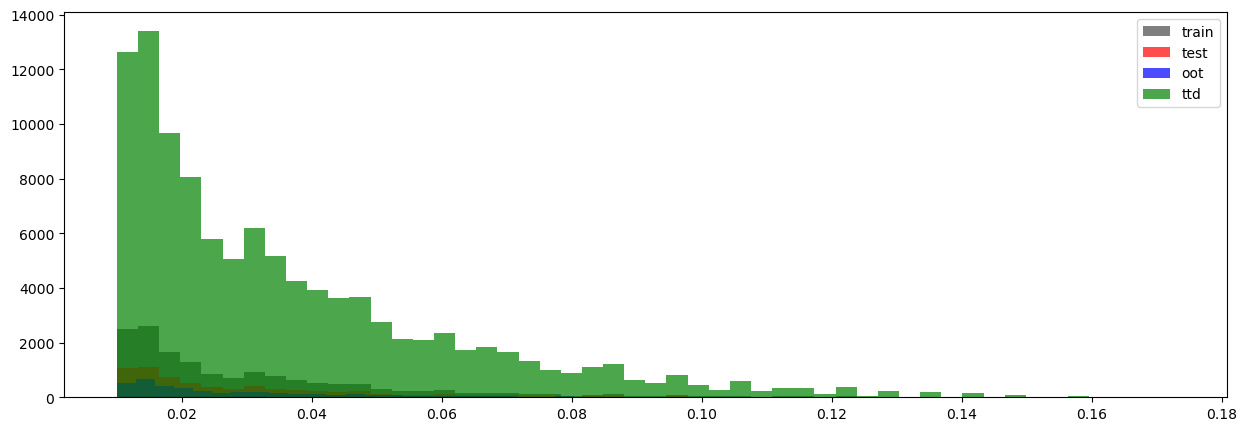

In [168]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [169]:
Train['p1'].value_counts(dropna= False).head()

p1
0.011049    371
0.010060    359
0.014709    258
0.011723    207
0.012424    205
Name: count, dtype: int64

In [170]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
sourcenonderogcount
inquiryshortterm12month
assetpropevercount
bankruptcystatus
criminalfelonycount
derogcount12month
evictioncount12month
criminalnonfelonycount
addrprevioustimeoldest
addrchangecount06month
addrcurrenttimenewest
lienjudgmentdollartotal
derogcount
bankruptcydismissed24month
inquirytelcom12month
lienjudgmenttaxcount
assetpropnewestmortgagetype
shorttermloanrequest
evictioncount
assetpersonalcount
bankruptcychapter
addrcurrentsubjectowned
businessassociationtimeoldest
addrinputdeedmailing
addrcurrentdeedmailing
sourcenonderogcount12month
inquirybanking12month
businessassociation
addrinputproblems
addrchangecount12month
assetpropnewestsaleprice
inquirycollections12month
educationprogramattended
assetpropsalepurchaseratio
criminalnonfelonycount12month
profliccount
lienjudgmentcount12month
addrinputtaxmarketvalue
addrinputtimenewest
assetproppurchasetimenewest
addrcurrentavmratio12monthprior
addrinputavmratio60monthprior
sourcenonderogcount

In [171]:
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],325.0,0.047020,0.048632,6912,134.0,0.045532,0.048245,2943.0,Yes
1,assetownership,[1],121.0,0.013506,0.017238,8959,60.0,0.015544,0.017250,3860.0,Yes
2,inquiryauto12month,[0],272.0,0.021509,0.025414,12646,121.0,0.022528,0.025378,5371.0,Yes
3,inquiryauto12month,[1],174.0,0.053953,0.052463,3225,73.0,0.050978,0.050466,1432.0,Yes
4,sourcenonderogcount,"[-inf, 2.0)",141.0,0.066825,0.056934,2110,53.0,0.059551,0.054717,890.0,Yes
5,sourcenonderogcount,"[2.0, 3.0)",172.0,0.034086,0.034847,5046,70.0,0.031949,0.035120,2191.0,Yes
6,sourcenonderogcount,"[3.0, 4.0)",97.0,0.021128,0.024734,4591,46.0,0.023457,0.024623,1961.0,Yes
7,sourcenonderogcount,"[4.0, inf)",36.0,0.008729,0.019654,4124,25.0,0.014196,0.019671,1761.0,Yes
8,inquiryshortterm12month,[0],383.0,0.025823,0.029989,14832,171.0,0.026824,0.029914,6375.0,Yes
9,inquiryshortterm12month,[1],63.0,0.060635,0.044061,1039,23.0,0.053738,0.041757,428.0,Yes


In [172]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
81 2.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.038837,0.110959,0.059722,17,16.0,1.0,5.88,20.99,20.25,50.0,29.75
1,0.028396,0.035861,0.031235,16,16.0,0.0,0.00,40.74,40.51,50.0,9.49
2,0.020111,0.028175,0.023011,16,16.0,0.0,0.00,60.49,60.76,50.0,10.76
3,0.012424,0.019900,0.015752,16,15.0,1.0,6.25,80.25,79.75,100.0,20.25
4,0.010060,0.012403,0.011303,16,16.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 19.62, 'KS': 29.75}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2981 86.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.043318,0.163759,0.063628,597,553.0,44.0,7.37,20.03,19.10,51.16,32.06
1,0.028781,0.043316,0.035346,596,579.0,17.0,2.85,40.02,39.10,70.93,31.83
2,0.019174,0.028781,0.023210,596,581.0,15.0,2.52,60.01,59.17,88.37,29.20
3,0.014539,0.019174,0.016479,596,589.0,7.0,1.17,80.01,79.52,96.51,16.99
4,0.010060,0.014529,0.012164,596,593.0,3.0,0.50,100.00,100.00,100.00,0.00


{'Gini': 44.03, 'KS': 32.06}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
649 17.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.035329,0.123295,0.055028,130,124.0,6.0,4.62,20.03,19.62,35.29,15.67
1,0.022573,0.035318,0.028108,130,126.0,4.0,3.08,40.06,39.56,58.82,19.26
2,0.016504,0.022563,0.019216,130,127.0,3.0,2.31,60.09,59.65,76.47,16.82
3,0.013642,0.016504,0.014763,130,128.0,2.0,1.54,80.12,79.91,88.24,8.33
4,0.010060,0.013642,0.011636,129,127.0,2.0,1.55,100.00,100.00,100.00,0.00


{'Gini': 24.060000000000002, 'KS': 19.26}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2444 105.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.056219,0.156621,0.080154,489,440.0,49.0,10.02,20.01,18.81,46.67,27.86
1,0.039172,0.056219,0.046594,489,462.0,27.0,5.52,40.02,38.56,72.38,33.82
2,0.025651,0.039172,0.032640,489,474.0,15.0,3.07,60.02,58.83,86.67,27.84
3,0.016200,0.025619,0.020198,489,479.0,10.0,2.04,80.03,79.31,96.19,16.88
4,0.010060,0.016175,0.013257,488,484.0,4.0,0.82,100.00,100.00,100.00,0.00


{'Gini': 42.57, 'KS': 33.82}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
559 9.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.035318,0.116119,0.050237,112,108.0,4.0,3.57,20.04,19.64,44.44,24.80
1,0.025278,0.035318,0.030548,112,112.0,0.0,0.00,40.07,40.00,44.44,4.44
2,0.017121,0.025213,0.020742,112,110.0,2.0,1.79,60.11,60.00,66.67,6.67
3,0.013723,0.017121,0.015221,112,111.0,1.0,0.89,80.14,80.18,77.78,2.40
4,0.010060,0.013705,0.012113,111,109.0,2.0,1.80,100.00,100.00,100.00,0.00


{'Gini': 13.43, 'KS': 24.8}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1652 74.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.042785,0.165101,0.062292,331,290.0,41.0,12.39,20.04,18.38,55.41,37.03
1,0.029691,0.042015,0.035179,330,321.0,9.0,2.73,40.01,38.72,67.57,28.85
2,0.018908,0.029644,0.023397,331,318.0,13.0,3.93,60.05,58.87,85.14,26.27
3,0.014472,0.018769,0.016093,330,322.0,8.0,2.42,80.02,79.28,95.95,16.67
4,0.010060,0.014472,0.012172,330,327.0,3.0,0.91,100.00,100.00,100.00,0.00


{'Gini': 43.53, 'KS': 37.03}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2688 18.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.028216,0.142061,0.045241,538,528.0,10.0,1.86,20.01,19.78,55.56,35.78
1,0.019382,0.028203,0.023185,538,534.0,4.0,0.74,40.03,39.78,77.78,38.00
2,0.015417,0.019382,0.017298,537,535.0,2.0,0.37,60.01,59.81,88.89,29.08
3,0.012424,0.015417,0.014119,538,538.0,0.0,0.00,80.02,79.96,88.89,8.93
4,0.010060,0.012424,0.011240,537,535.0,2.0,0.37,100.00,100.00,100.00,0.00


{'Gini': 44.72, 'KS': 38.0}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2991 62.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.048579,0.156621,0.074375,599,571.0,28.0,4.67,20.03,19.49,45.16,25.67
1,0.031887,0.048560,0.038996,598,578.0,20.0,3.34,40.02,39.23,77.42,38.19
2,0.020565,0.031887,0.026145,598,594.0,4.0,0.67,60.01,59.51,83.87,24.36
3,0.014709,0.020561,0.017299,598,592.0,6.0,1.00,80.01,79.72,93.55,13.83
4,0.010060,0.014709,0.012651,598,594.0,4.0,0.67,100.00,100.00,100.00,0.00


{'Gini': 40.82, 'KS': 38.19}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1490 66.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.053560,0.172651,0.077257,299,265.0,34.0,11.37,20.07,18.61,51.52,32.91
1,0.035526,0.052795,0.043299,297,287.0,10.0,3.37,40.00,38.76,66.67,27.91
2,0.023007,0.035526,0.029397,299,286.0,13.0,4.35,60.07,58.85,86.36,27.51
3,0.015509,0.023007,0.019041,298,293.0,5.0,1.68,80.07,79.42,93.94,14.52
4,0.010060,0.015509,0.012938,297,293.0,4.0,1.35,100.00,100.00,100.00,0.00


{'Gini': 41.15, 'KS': 32.91}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
282 7.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.033119,0.105405,0.048552,57,53.0,4.0,7.02,20.21,19.27,57.14,37.87
1,0.021199,0.031807,0.025208,56,54.0,2.0,3.57,40.07,38.91,85.71,46.80
2,0.016451,0.020899,0.018771,57,57.0,0.0,0.00,60.28,59.64,85.71,26.07
3,0.012403,0.016353,0.014498,56,55.0,1.0,1.79,80.14,79.64,100.00,20.36
4,0.010060,0.012403,0.010967,56,56.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 52.459999999999994, 'KS': 46.8}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
54 0.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.039862,0.082809,0.053993,11,11.0,0.0,0.0,20.37,20.37,NaN,NaN
1,0.029949,0.039581,0.033957,11,11.0,0.0,0.0,40.74,40.74,NaN,NaN
2,0.015618,0.027315,0.021264,11,11.0,0.0,0.0,61.11,61.11,NaN,NaN
3,0.013642,0.015612,0.014688,11,11.0,0.0,0.0,81.48,81.48,NaN,NaN
4,0.010685,0.013397,0.012122,10,10.0,0.0,0.0,100.00,100.00,NaN,NaN


{'Gini': nan, 'KS': nan}


### Basic Checks

In [173]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(21741.0, 15871.0, 6803.0)

In [174]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [175]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    15222.000000
 mean         0.031130
 std          0.022306
 min          0.010060
 25%          0.015266
 50%          0.022929
 75%          0.039537
 max          0.172651
 Name: p1, dtype: float64,
 count    15222.000000
 mean         0.031130
 std          0.022306
 min          0.010060
 25%          0.015266
 50%          0.022929
 75%          0.039537
 max          0.172651
 Name: p1, dtype: float64)

In [176]:
import datetime

In [177]:
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [178]:
Train['fico_pb'].describe()

count    15854.000000
mean       660.470102
std        115.057743
min          0.000000
25%        636.000000
50%        674.000000
75%        710.000000
max        884.000000
Name: fico_pb, dtype: float64

In [179]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [180]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,12343,932.0,621.0,45.0,0.050876
a.550-600,16339,3901.0,1659.0,104.0,0.044566
b.600-629,15333,5859.0,2140.0,106.0,0.038924
c.630-659,18605,8778.0,3585.0,147.0,0.033848
d.660-689,17281,9786.0,4841.0,87.0,0.029158
e.690-714,10126,6442.0,3420.0,33.0,0.026202
f.715-739,5344,3800.0,2031.0,19.0,0.025636
g.740+,6464,5002.0,2934.0,16.0,0.025307
h.Missing,5178,899.0,510.0,61.0,0.049151


In [181]:
TTD.shape

(107013, 148)

Closing connection _sid_8eaf at exit
H2O session _sid_8eaf closed.
